# Project

The objective of this project was to understand the process of music generation with AI. Dataset consisted of 52 MIDI samples of nursery rhymes and children’s songs, in the key of C major. Music 21, a python toolkit for computer aided musicology, developed by researchers at MIT, was used to read and process the MIDI files. Keras was used to build the model. Tensorboard was used to visualize the training process. A corpus consisting of all the unique notes and chords along with their durations, was created. The notes/chord objects (including durations) are converted to a string format which are in turn encoded as integers. This list is used to create the input sequences of length 50. The output of each input sequence is the next note/chord that is observed after the sequence of notes in the input sequence. Training data consists of 5074 input sequences. The outputs are one hot encoded. The unique number of output classes are 247. Three architectures were considered.

LSTM without dropout layer

LSTM with one dropout layer

Bidirectional LSTM with one dropout layer

Reweighted sampling was used to introduce randomness while generating new notes. Sampling at different softmax temperatures was considered. 

Model produces a different piece of music each time it runs. Following are some of the generated samples:
Generated sample 1:
https://soundcloud.com/user-518020118/two-lstm-40-epochs-sampled-075
Generated sample 2:
https://soundcloud.com/user-518020118/generated-music-two-lstm-sampled-06
Generated sample 3:
https://soundcloud.com/user-518020118/bilstm-2layer1dropout-sampled-10

## Future work

1. Increase the number of MIDI samples in the training dataset.
2. Expand to include other instruments and other key signatures in addition to C major.
3. Process the note duration independent of the note/chord.
4. For the music to sound more coherent, try using pieces with the same style. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import music21
from music21 import converter,note,chord,stream,corpus,metadata,duration,graph
import glob
from sklearn.preprocessing import OneHotEncoder
from keras import layers
from keras import models
import keras
import re
import seaborn as sns
import matplotlib as mpl

import fractions
np.set_printoptions(suppress= True)

%matplotlib inline

Using TensorFlow backend.
/Users/poojadeshpande91/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/poojadeshpande91/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/poojadeshpande91/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/pooj

In [2]:
params = {'axes.titlesize':20,
          'axes.labelsize':18,
          'xtick.labelsize':15,
          'ytick.labelsize':15
          }
mpl.rcParams.update(params)
plt.rcParams['figure.figsize'] = 15,10

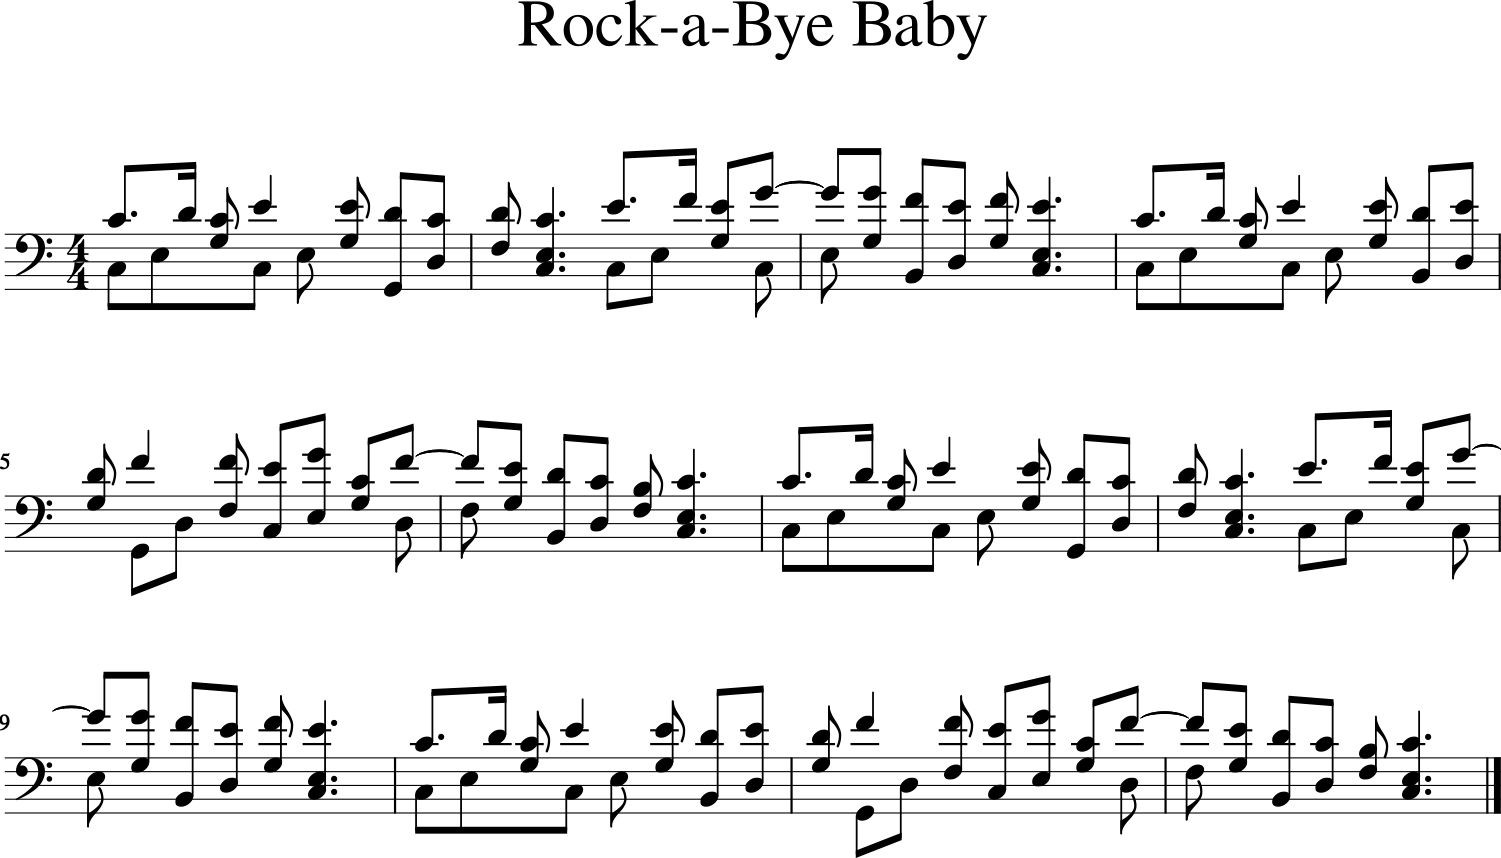

In [3]:
#View an excerpt of Twinkle Twinkle
s = converter.parse('../data/OnlineMidi (1).mid')
m = metadata.Metadata(title = "Rock-a-Bye Baby")
s.insert(0,m)
s.show()

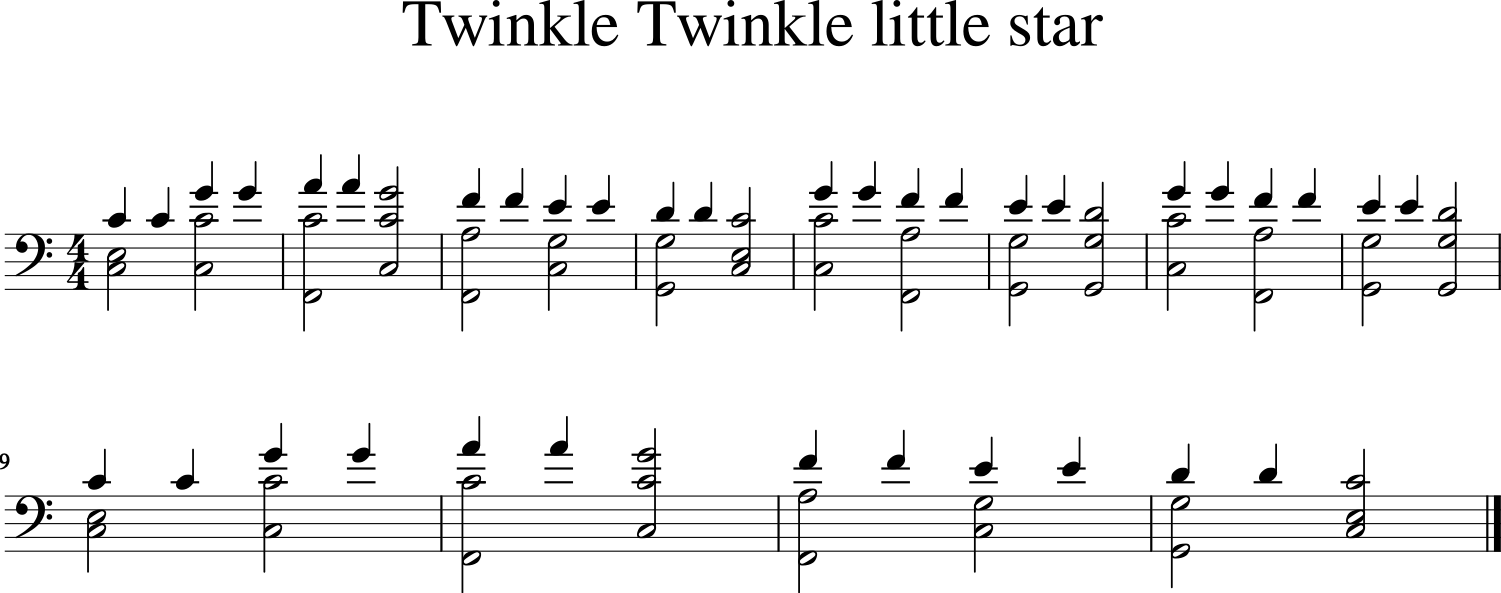

In [4]:
#View an excerpt of Humpty Dumpty
s = converter.parse('../data/OnlineMidi (3).mid')
m = metadata.Metadata(title = "Twinkle Twinkle little star")
s.insert(0,m)
s.show()

In [5]:
#Excerpt of the Score object when flattened

for obj in s.recurse():
     print(obj.offset, obj, obj.activeSite)


0.0 <music21.metadata.Metadata object at 0x10fe21810> <music21.stream.Score 0x13e245bd0>
0.0 <music21.stream.Part 0x13e3d8390> <music21.stream.Score 0x13e245bd0>
0.0 Piano <music21.stream.Part 0x13e3d8390>
0.0 <music21.tempo.MetronomeMark Quarter=95.0> <music21.stream.Part 0x13e3d8390>
0.0 <music21.stream.Voice 0x13e3ee450> <music21.stream.Part 0x13e3d8390>
0.0 <music21.note.Note C> <music21.stream.Voice 0x13e3ee450>
1.0 <music21.note.Note C> <music21.stream.Voice 0x13e3ee450>
2.0 <music21.note.Note G> <music21.stream.Voice 0x13e3ee450>
3.0 <music21.note.Note G> <music21.stream.Voice 0x13e3ee450>
4.0 <music21.note.Note A> <music21.stream.Voice 0x13e3ee450>
5.0 <music21.note.Note A> <music21.stream.Voice 0x13e3ee450>
6.0 <music21.chord.Chord G4 C4 C3> <music21.stream.Voice 0x13e3ee450>
8.0 <music21.note.Note F> <music21.stream.Voice 0x13e3ee450>
9.0 <music21.note.Note F> <music21.stream.Voice 0x13e3ee450>
10.0 <music21.note.Note E> <music21.stream.Voice 0x13e3ee450>
11.0 <music21.note.N

# Plots to analyze the training data

In [6]:
bunch_of_notes = stream.Stream()
for file in glob.glob('../data/OnlineMidi*'):
    score = converter.parse(file)
    for obj in score.recurse():
        
        if isinstance(obj,(note.Note) or (chord.Chord)):
            bunch_of_notes.append(obj)
            
            
 

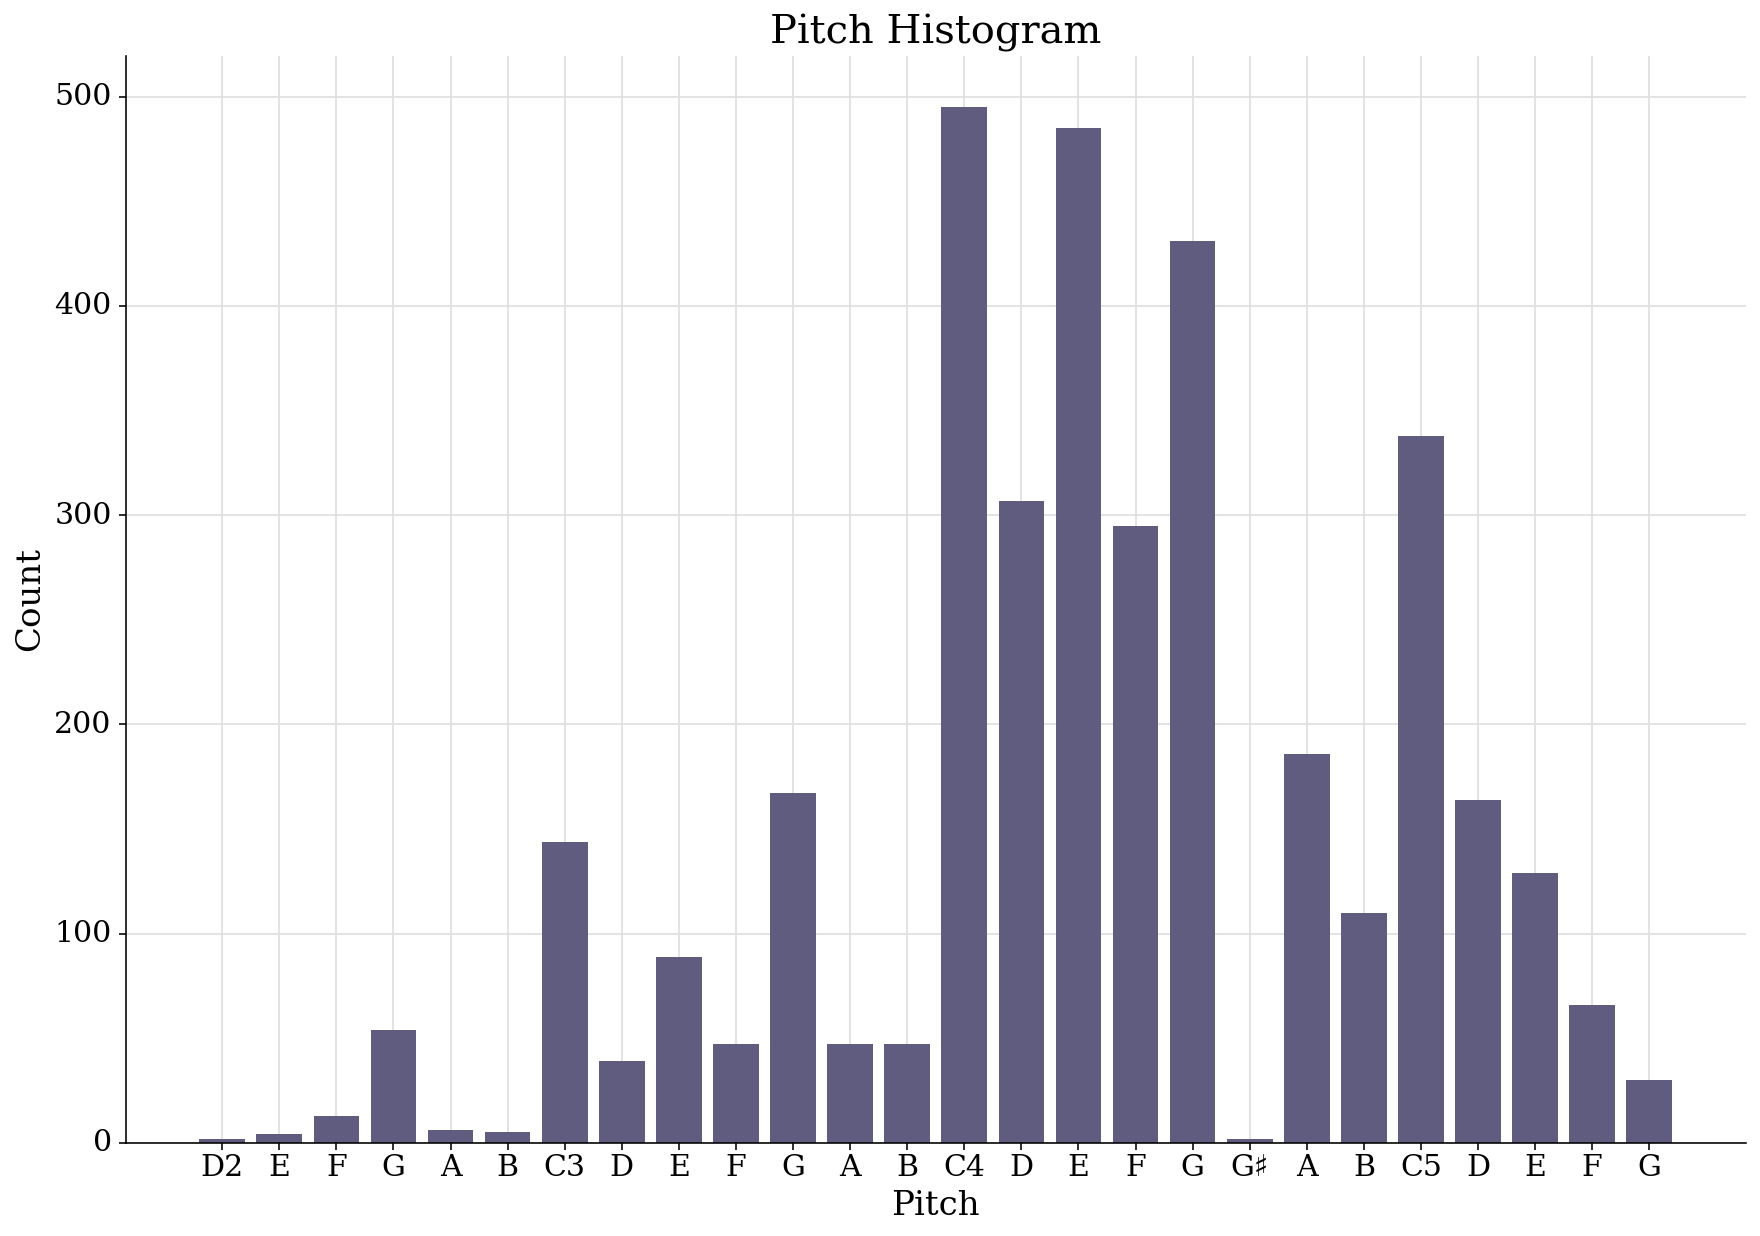

In [7]:
bunch_of_notes.plot('histogram','pitch',figureSize = (15,10),tickFontSize = 15,labelFontSize = 17,titleFontSize = 20,markerSize = 15)



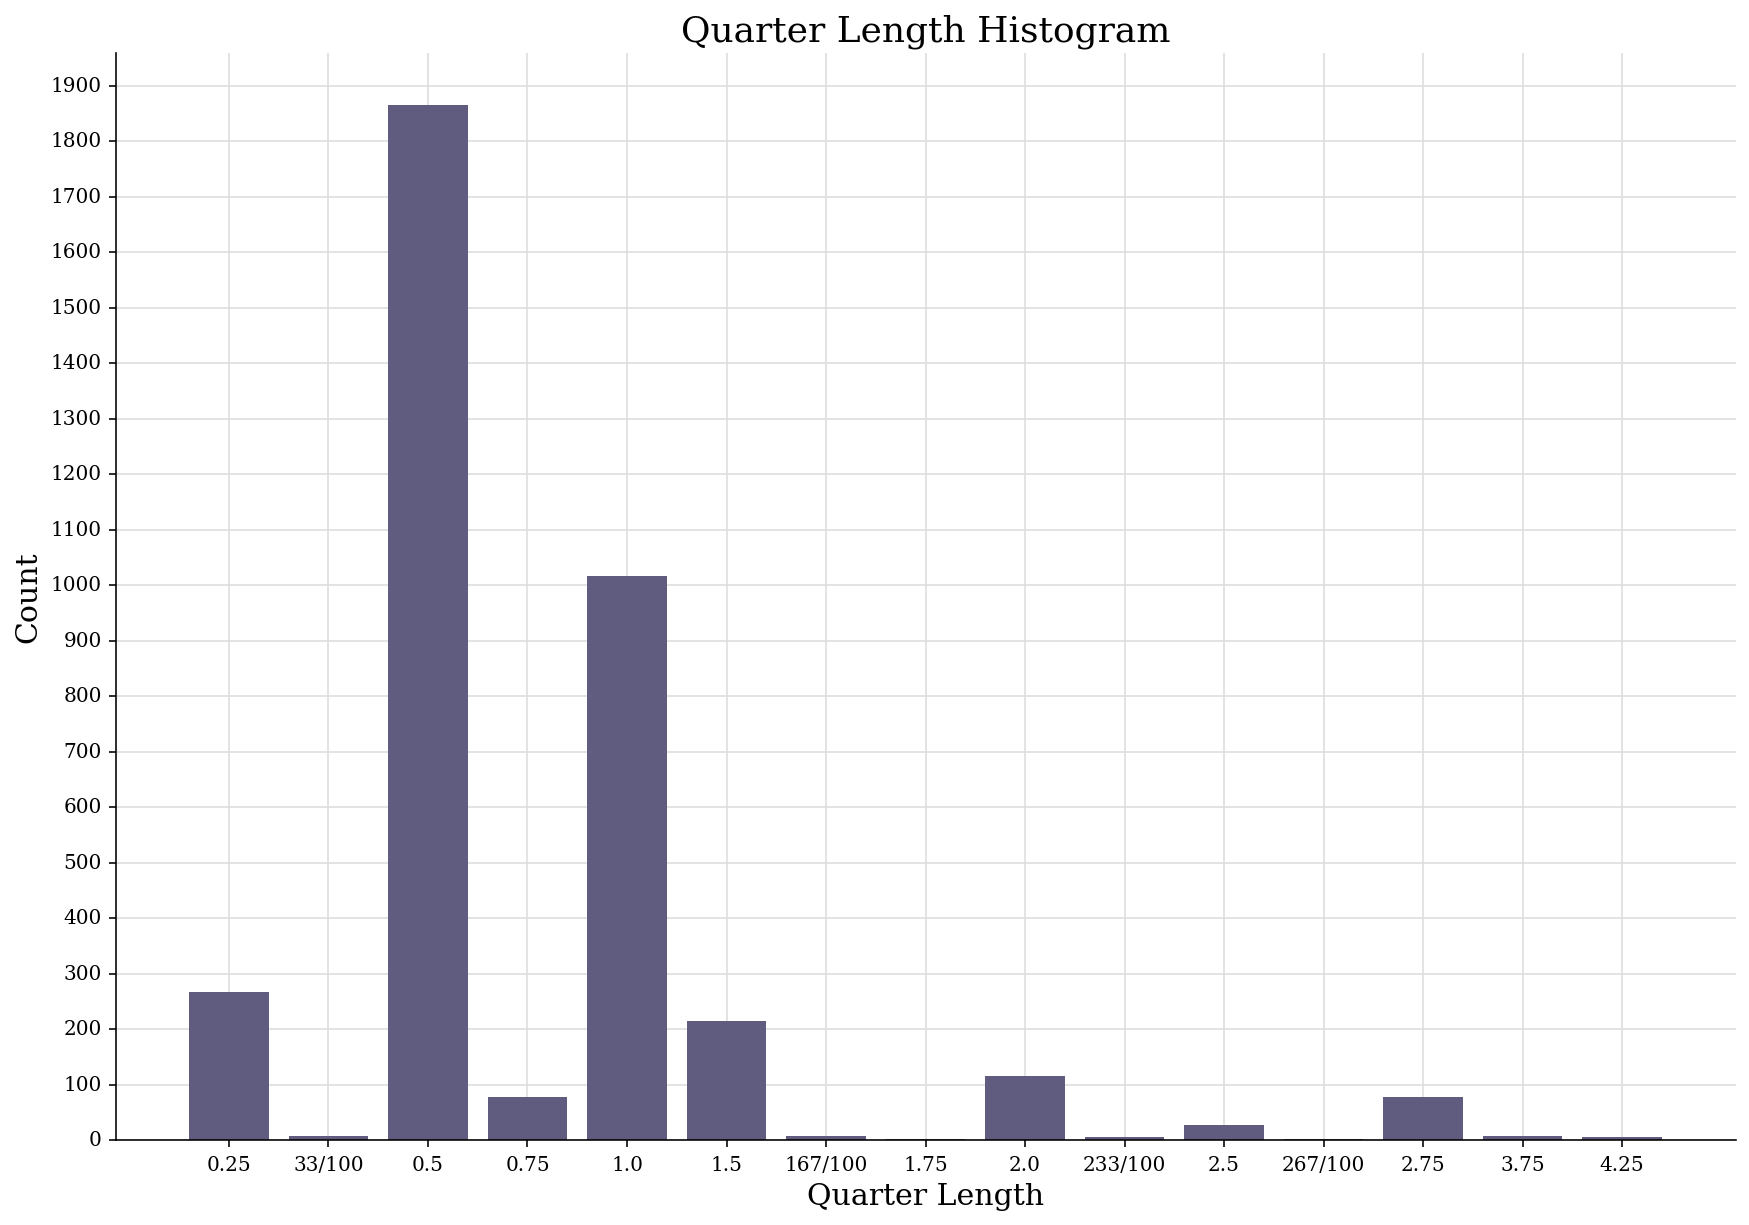

In [9]:
bunch_of_notes.plot('histogram','quarterLength',figureSize = (15,10),tickFontSize = 10,labelFontSize = 15,titleFontSize = 18)

# Data preprocessing

In [10]:
#Read the files
#Store the notes, chords and rests along with their duration
notes = []
for file in glob.glob('../data/OnlineMidi*'):
    score = converter.parse(file)
    for obj in score.recurse():
        if isinstance(obj,note.Note):
            notes.append(str(obj.pitch)+"$"+str(obj.duration.quarterLength))
        if isinstance(obj,chord.Chord):
            notes.append('.'.join(str(n) for n in obj.normalOrder)+"$"+str(obj.duration.quarterLength))

In [11]:
#Number of elements in the notes object
print("Number of notes and chords : {}".format(len(notes)))
print("A snippet of the notes object : \n{}".format(notes[0:20]))

Number of notes and chords : 5124
A snippet of the notes object : 
['G3$1.0', 'C4$0.5', 'C4$0.5', 'C4$0.5', 'C4$0.5', 'C4$1.0', 'C4$0.5', 'C4$0.5', 'D4$0.5', 'D4$0.5', 'D4$0.5', 'D4$0.5', 'D4$1.0', 'D4$0.5', 'D4$0.5', 'E4$0.5', 'E4$0.5', 'E4$0.5', 'E4$0.5', 'G4$1.0']


In [12]:
#String to integer data
unique_notes = set(notes)
len(unique_notes)

247

In [13]:
#Create a dictionary to map each unique note to an integer
mapping = {}
for i,note in enumerate(sorted(unique_notes)):
    mapping[note] = i

In [14]:
#Create input and output sequences
input_seq = []
output_seq = []

input_int = []
output_int = []

#Sequence length
seq_length = 50

iterate_till = len(notes) - seq_length 


#input and output sequence
for i in range(0,iterate_till,1):
    input_seq.append(notes[i:seq_length+i])
    output_seq.append(notes[seq_length+i])
    
    input_int.append([mapping[n] for n in notes[i:seq_length+i]])
    output_int.append(mapping[notes[seq_length+i]])
    
#Check the lengths of all the lists 
print("Length of string input and output sequence : {}, {}".format(len(input_seq),len(output_seq)))
print("Length of integer mapped input and output sequences : {}, {}".format(len(input_int),len(output_int)))


Length of string input and output sequence : 5074, 5074
Length of integer mapped input and output sequences : 5074, 5074


In [15]:
#Reshape the data into a format that's compatible with LSTM
#(batch_size, timesteps, no_of_features)
lstm_input = np.array(input_int).reshape((len(input_int),seq_length,1))

In [16]:
#Normalize the input
lstm_input = lstm_input/len(unique_notes)

In [17]:
#One hot encode the output

encoder = OneHotEncoder(categories = 'auto')
out = np.array(output_int).reshape(-1,1)
model_output = encoder.fit_transform(out)
n_class = model_output.shape[1]
n_class

247

# LSTM model

In [18]:
#Define the model architecture
model = models.Sequential()
model.add(layers.LSTM(256, input_shape = (lstm_input.shape[1],lstm_input.shape[2]), return_sequences = True))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(512))
#model.add(layers.Dropout(0.3))
# model.add(layers.LSTM(256))
# model.add(layers.Dense(256))
# model.add(layers.Dropout(0.3))
model.add(layers.Dense(n_class,activation = 'softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
#Compile the model
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy',metrics = ['acc'])

In [20]:
#Set up callbacks list. Use ModelCheckpoints to save the weights of the model
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath ='../output/weights1.h5', monitor = 'loss',save_best_only = True ),
                  keras.callbacks.TensorBoard(log_dir = '../log_dir_1',write_graph = True, update_freq = 'epoch')]

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 256)           264192    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               1574912   
_________________________________________________________________
dense_1 (Dense)              (None, 247)               126711    
Total params: 1,965,815
Trainable params: 1,965,815
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(lstm_input,model_output, epochs = 40,batch_size = 64, callbacks = callbacks_list )

Instructions for updating:
Use tf.cast instead.
Epoch 1/40
5074/5074 [==============================] - 78s 15ms/step - loss: 4.7120 - acc: 0.0445
Epoch 2/40
5074/5074 [==============================] - 76s 15ms/step - loss: 4.4320 - acc: 0.0574
Epoch 3/40
5074/5074 [==============================] - 90s 18ms/step - loss: 4.3090 - acc: 0.0650
Epoch 4/40
5074/5074 [==============================] - 93s 18ms/step - loss: 4.1923 - acc: 0.0698
Epoch 5/40
5074/5074 [==============================] - 87s 17ms/step - loss: 4.0987 - acc: 0.0745
Epoch 6/40
5074/5074 [==============================] - 74s 15ms/step - loss: 3.9828 - acc: 0.0970
Epoch 7/40
5074/5074 [==============================] - 73s 14ms/step - loss: 3.8606 - acc: 0.0966
Epoch 8/40
5074/5074 [==============================] - 73s 14ms/step - loss: 3.7224 - acc: 0.1173
Epoch 9/40
5074/5074 [==============================] - 74s 14ms/step - loss: 3.5515 - acc: 0.1413
Epoch 10/40
5074/5074 [==============================] - 76s 

## Training loss plot

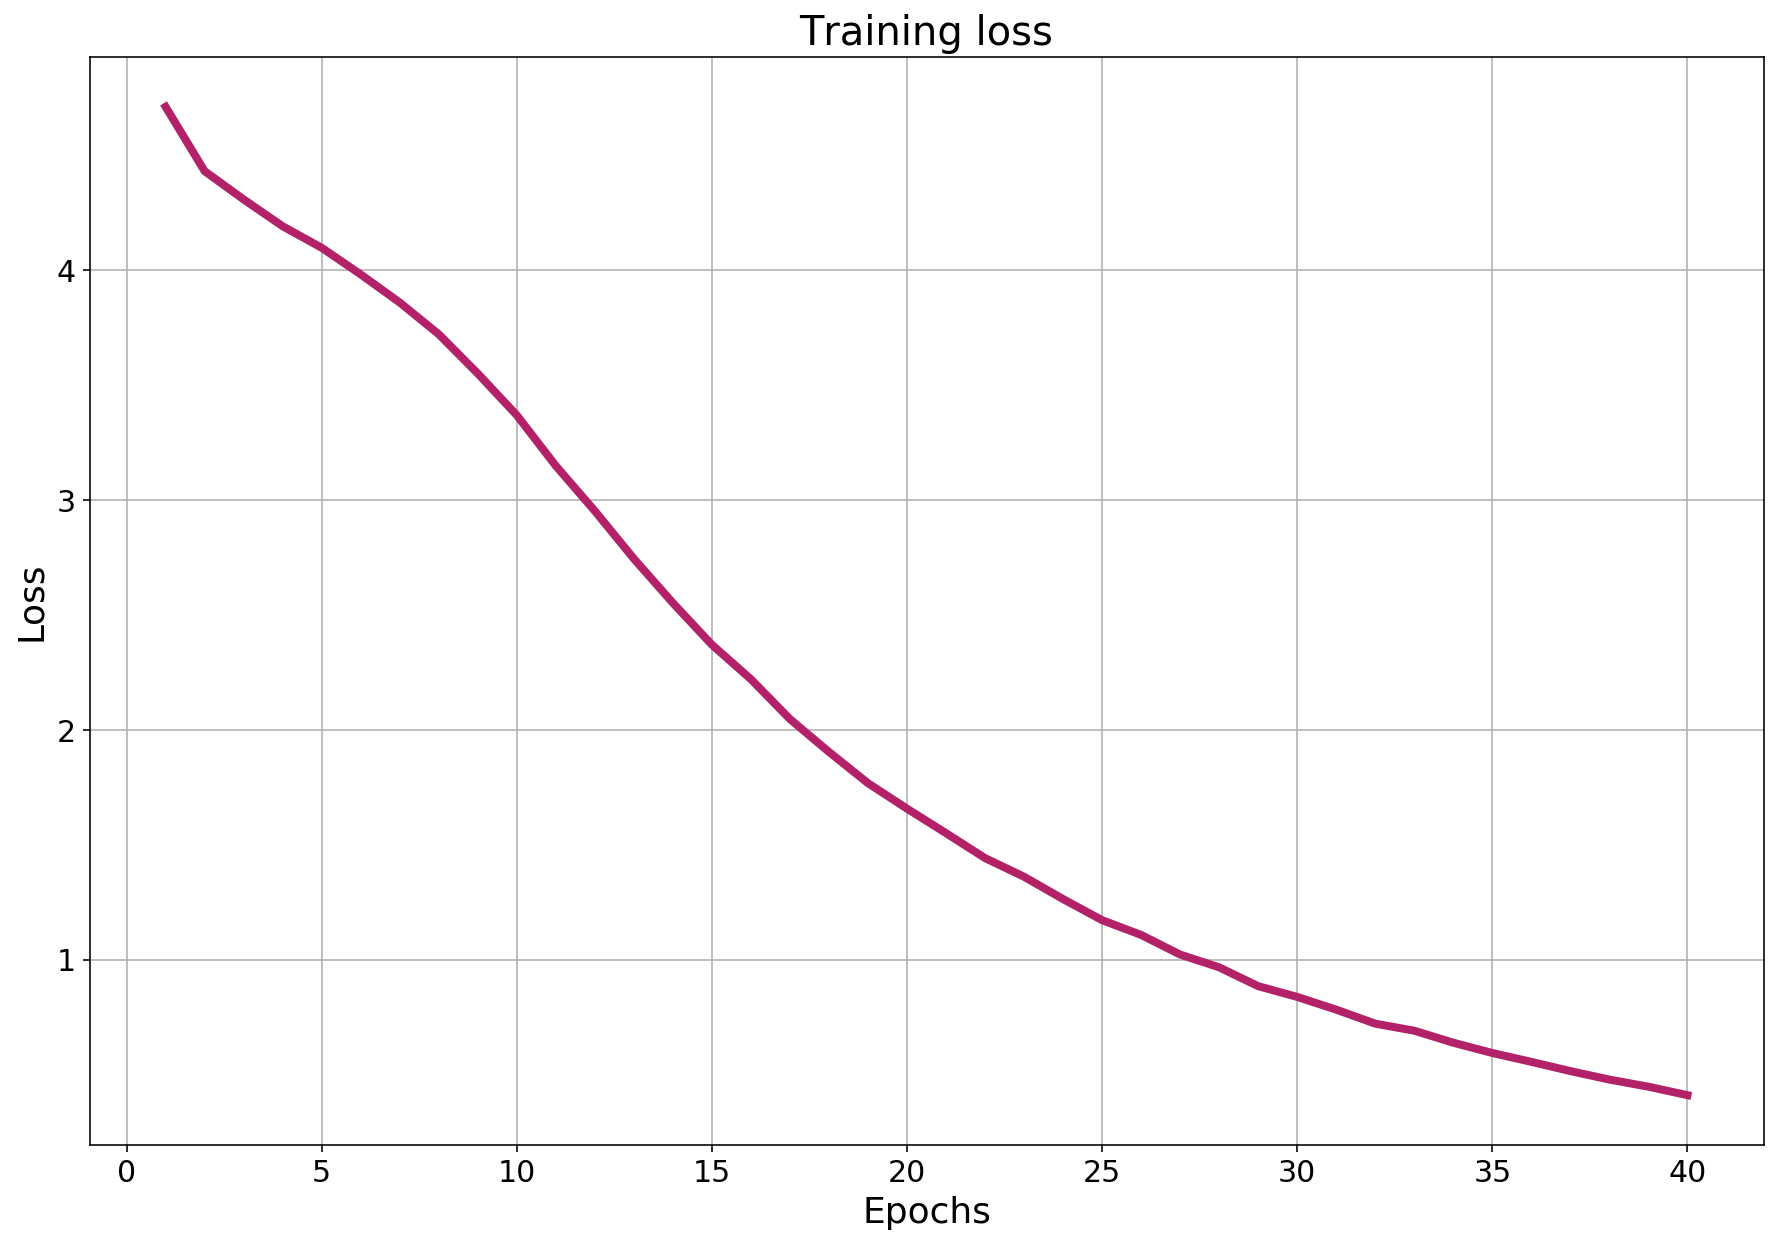

In [23]:

plt.plot(list(range(1,41,1)), history.history['loss'], color = '#B32268', linewidth = 4)


plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

# Music Generation

In [24]:
#Recreate the model, and load the weights
model = models.Sequential()
model.add(layers.LSTM(256, input_shape = (lstm_input.shape[1],lstm_input.shape[2]),return_sequences= True))
#model.add(layers.Dropout(0.3))
model.add(layers.LSTM(512))
#model.add(layers.Dropout(0.3))
# model.add(layers.LSTM(256))
# model.add(layers.Dense(256))
# model.add(layers.Dropout(0.3))
model.add(layers.Dense(n_class,activation = 'softmax'))

In [25]:
#Compile the model
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy')

In [26]:
#Load the weights
model.load_weights('../output/weights_2layer.h5')

In [92]:
#Use the previous mapping dictionary to map integers to notes
int_to_note = {}
for i,j in mapping.items():
    int_to_note[j] = i
    

In [93]:
next_note = []
pattern = []

In [94]:
#Choose a random starting point from the list of input sequences
start_input_index = np.random.randint(0,len(input_int))
network_input = input_int[start_input_index]
pattern = input_int[start_input_index]


In [95]:
print(input_int[start_input_index])
print(input_seq[start_input_index])

[182, 131, 131, 131, 231, 209, 183, 160, 136, 134, 134, 133, 160, 184, 183, 183, 235, 139, 139, 230, 230, 182, 182, 182, 131, 131, 131, 191, 237, 215, 112, 237, 112, 125, 153, 191, 237, 215, 112, 237, 189, 139, 167, 189, 189, 237, 213, 213, 112, 237]
['E3$0.5', 'C3$0.5', 'C3$0.5', 'C3$0.5', 'G3$1.0', 'F3$0.5', 'E3$1.0', 'D3$0.5', 'C3$2.75', 'C3$1.5', 'C3$1.5', 'C3$1.0', 'D3$0.5', 'E3$1.5', 'E3$1.0', 'E3$1.0', 'G3$2.75', 'C4$0.5', 'C4$0.5', 'G3$0.5', 'G3$0.5', 'E3$0.5', 'E3$0.5', 'E3$0.5', 'C3$0.5', 'C3$0.5', 'C3$0.5', 'E4$1.0', 'G4$0.5', 'F4$1.0', 'A4$0.5', 'G4$0.5', 'A4$0.5', 'B4$0.5', 'C5$1.5', 'E4$1.0', 'G4$0.5', 'F4$1.0', 'A4$0.5', 'G4$0.5', 'E4$0.5', 'C4$0.5', 'D4$1.5', 'E4$0.5', 'E4$0.5', 'G4$0.5', 'F4$0.5', 'F4$0.5', 'A4$0.5', 'G4$0.5']


In [96]:
#Reweight the sampling to introduce randomness
def sample(preds, temperature):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds)
    return probas

In [97]:
num_notes_to_generate = 150

In [98]:
#Generate predictions from the model. Apply reweighted sampling
i = 0
for num in range(150):
    network_input = np.reshape(network_input,(1,50,1))
    
    network_input = network_input.astype('float')/len(unique_notes)
    
    probs = model.predict(network_input)[0]
    
#     print(num,"\n", np.argmax(probs),np.max(probs))
    
   
    index = np.argmax(sample(probs,0.5))
#     print(index,np.max(sample(probs,0.75)),'\n')
    if index != np.argmax(probs):
        i = i+1
    

    pattern.append(index)
    
    network_input = pattern[num+1:len(pattern)]
print("Percentage of notes that were changed by sample reweight : {:.4}%".format(i*100/num_notes_to_generate))    

Percentage of notes that were changed by sample reweight : 20.67%


In [99]:
#Length of the generated pattern ---This includes the input training sequence
len(pattern)

200

In [100]:
generated = []
output_notes = []
offset = 0


In [101]:
#Map the integers to the notes
for i in pattern[50:]:
    generated.append(int_to_note[i])


In [102]:
# for i,j in enumerate(generated):
#     print(i,j)


In [103]:
output_notes = []
offset  = 0

In [104]:
from music21 import note

In [105]:
#For each element in the generated pattern, check if it is a note or a chord. If it is a note, create a note object 
#and append to the output. If it is a chord, create note objects for all the notes in the chord. Create a chord
#object with these note objects, and append to the output. Also, check the duration of the note and increase the offset
for element in generated:
    if bool(re.match(r'^[A-Z]',element)):
        l = element.split('$')
        n = note.Note(l[0])
        n.duration.quarterLength = eval(l[1])
        n.offset = offset
        output_notes.append(n)
        
    if bool(re.match(r'^\d',element)):
        l = element.split('$')
        le = l[0].split('.')
        notes_1 = []
        for ns in le:
            new_note = note.Note(int(ns))
            notes_1.append(new_note)
        ch = chord.Chord(notes_1)
        ch.duration.quarterLength = eval(l[1])
        ch.offset = offset
        output_notes.append(ch)
    
    offset = offset+eval(l[1])
    
        
        
    
    
    
          

In [106]:
#Create a stream of all the output notes
music = stream.Stream(output_notes)


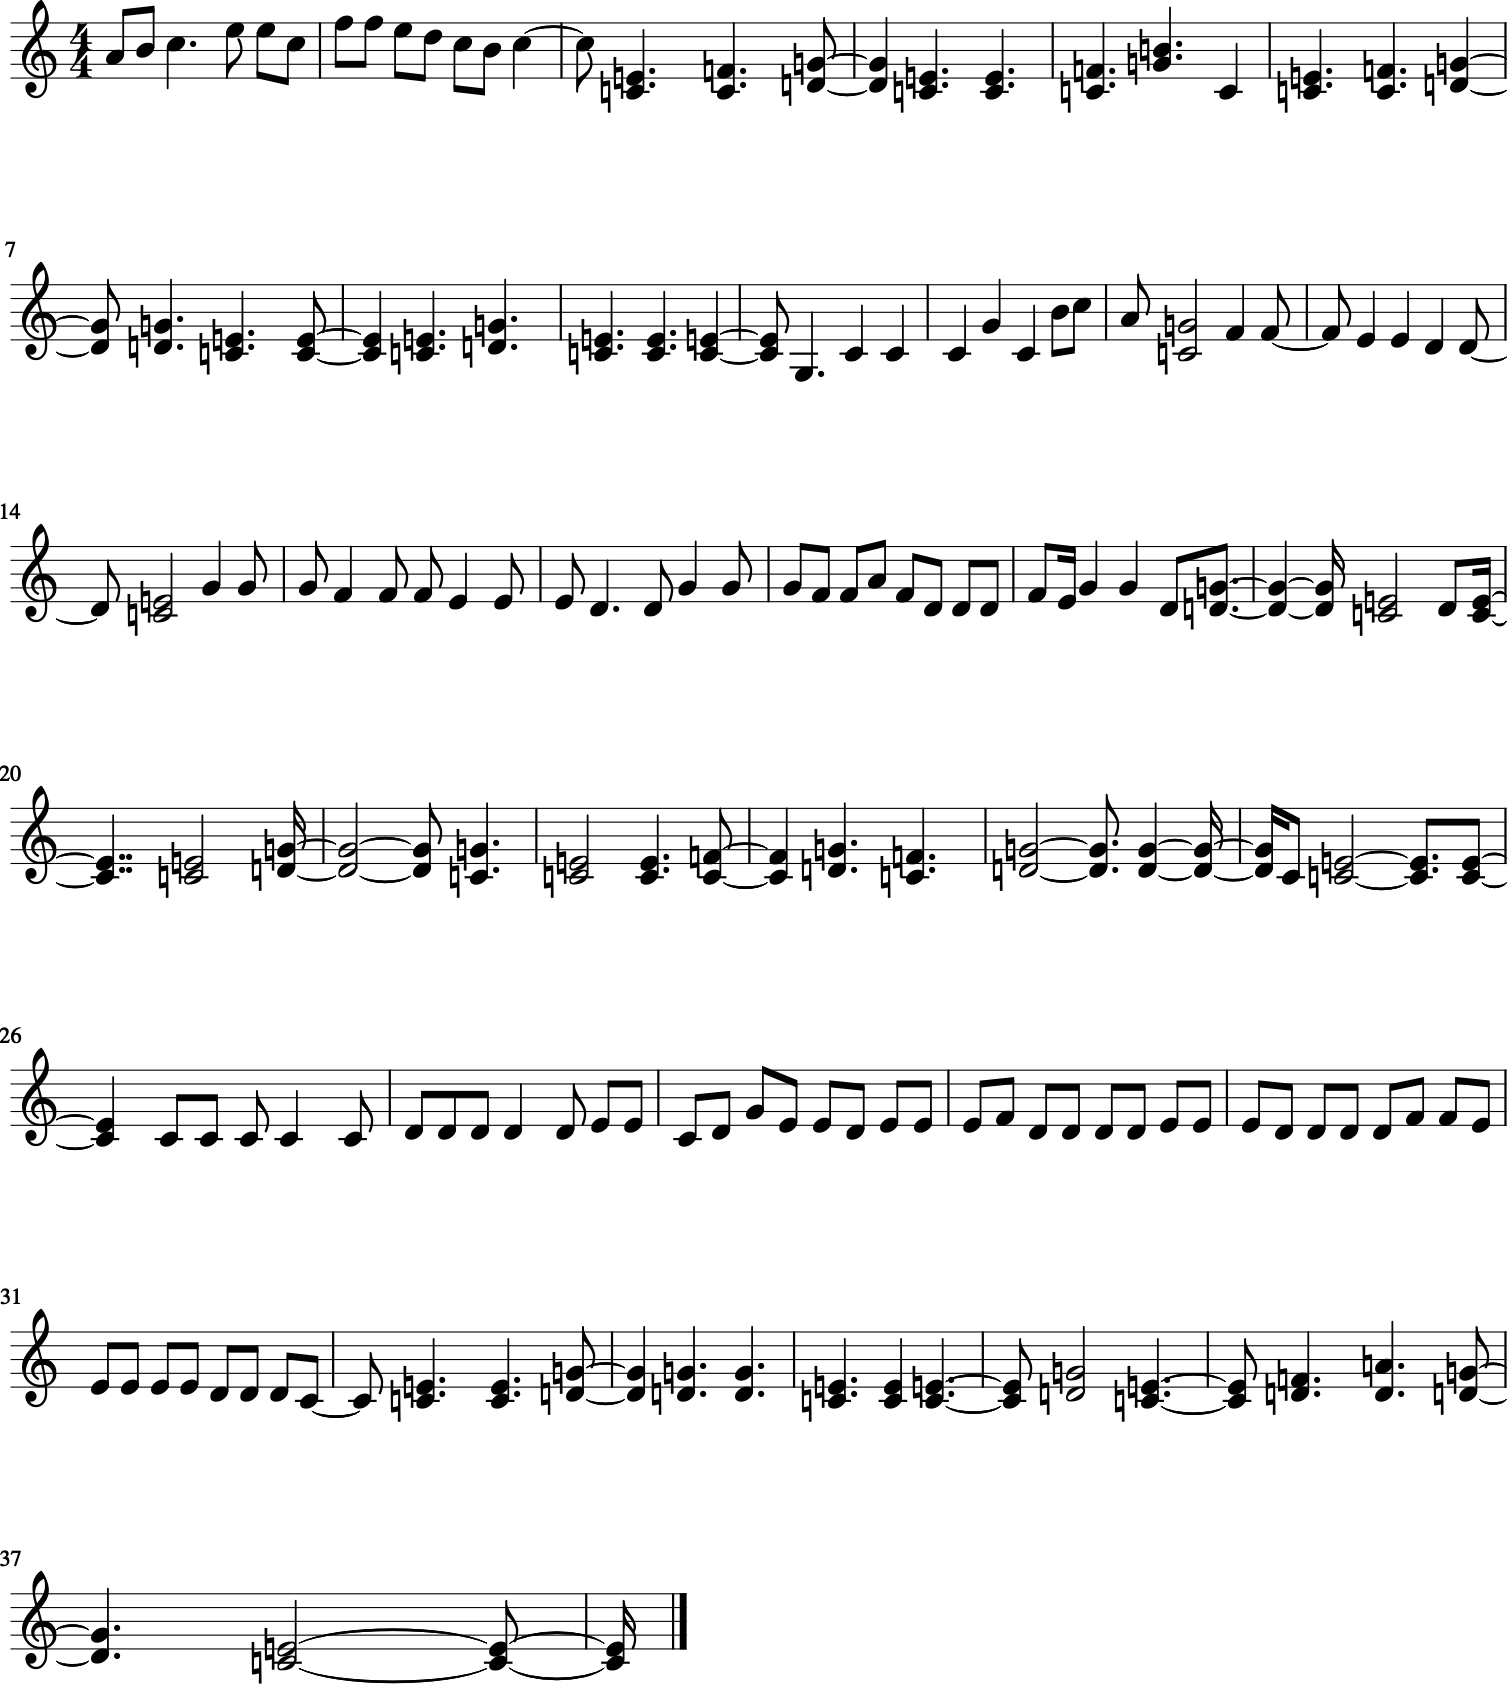

In [107]:
#View the stream
music.show()

In [108]:
#Convert to midi and write to disk
music.write('midi','../output/two_LSTM1dropout_30_epochs_sampled_0.5_1.mid')

'../output/two_LSTM1dropout_30_epochs_sampled_0.5_1.mid'

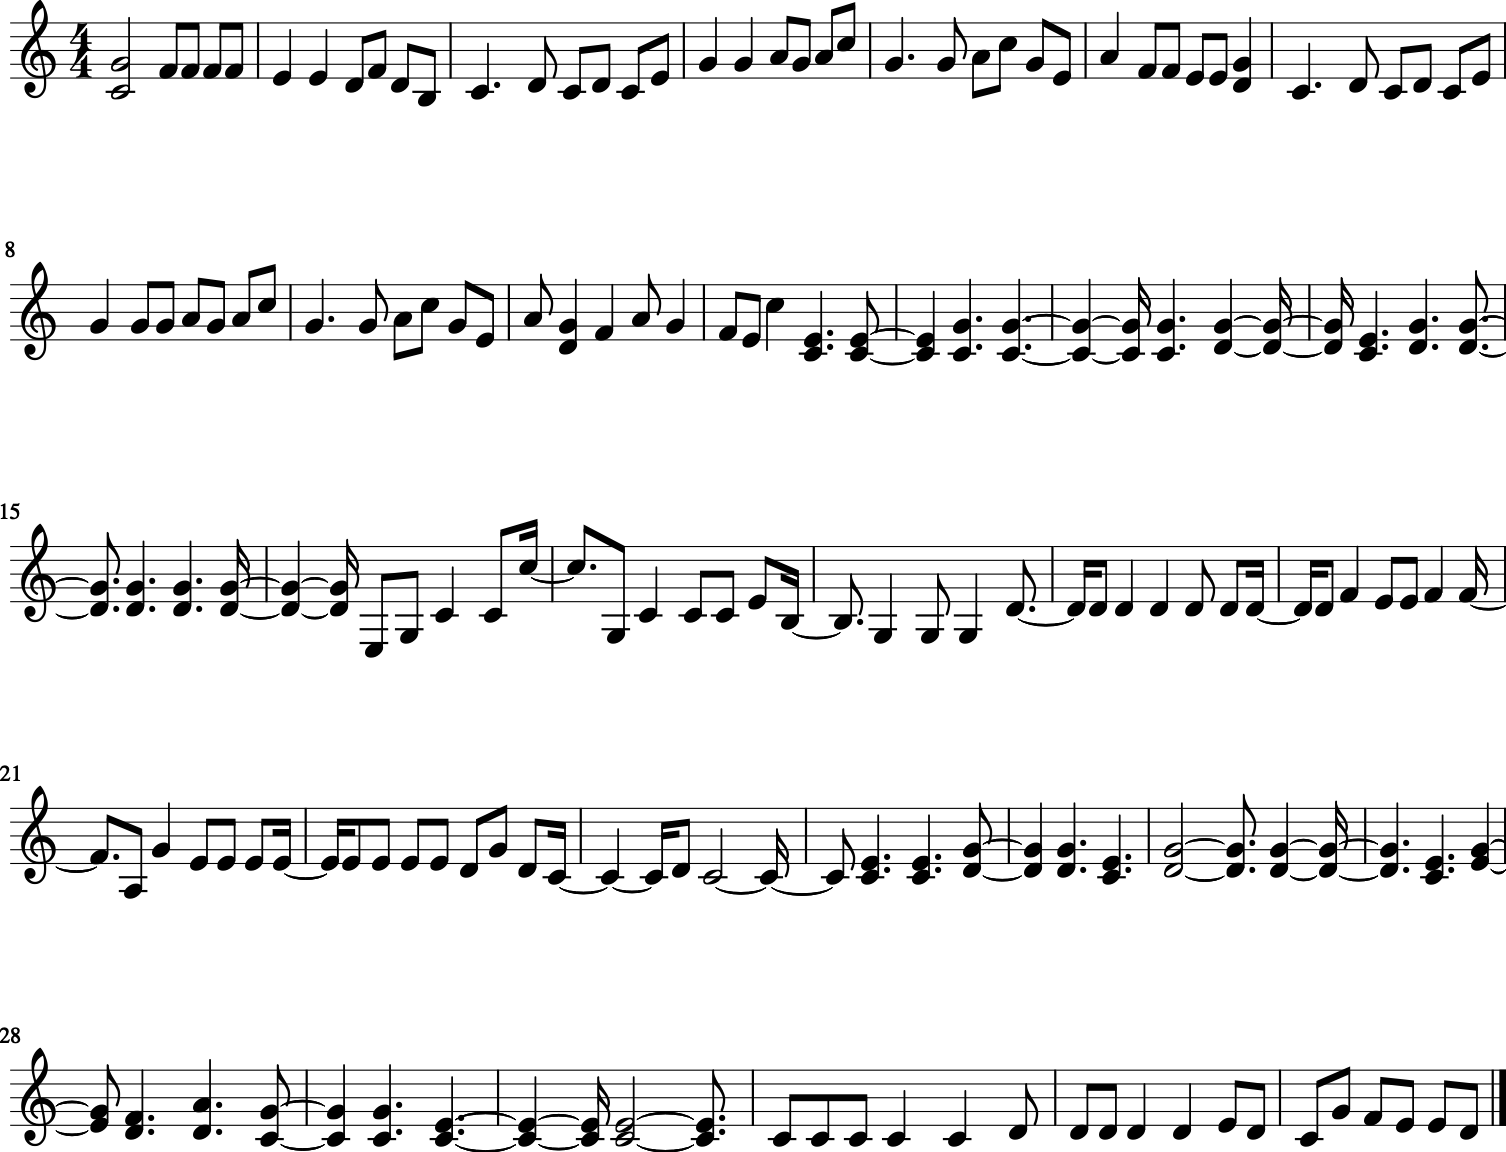

In [109]:
#Results from a saved model
music = converter.parse('../output/two_LSTM_40_epochs_sampled_0.75.mid')
music.show()

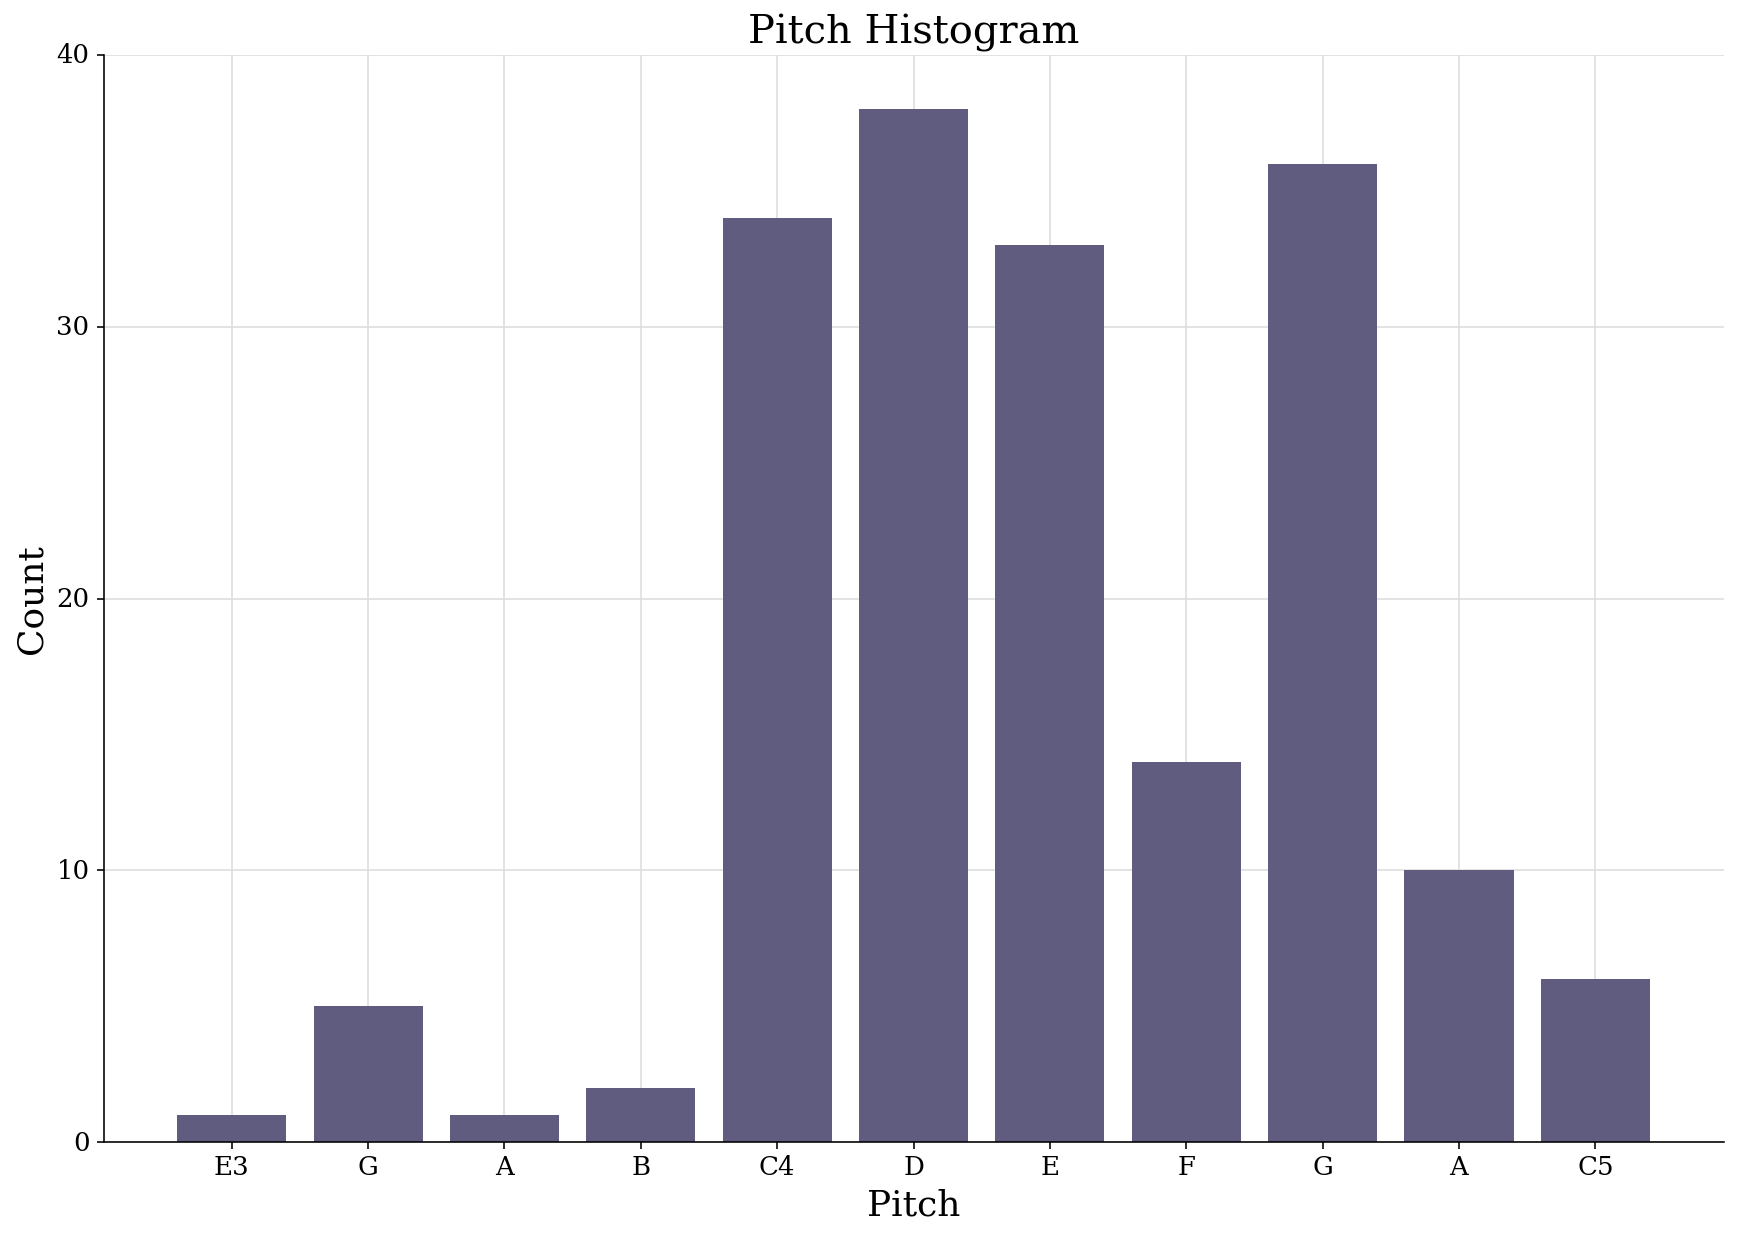

In [110]:
#Visualization of the output notes
music.plot('histogram','pitch',figureSize = (15,10),tickFontSize = 13,titleFontSize = 20, labelFontSize = 18,textFontSize = 12)

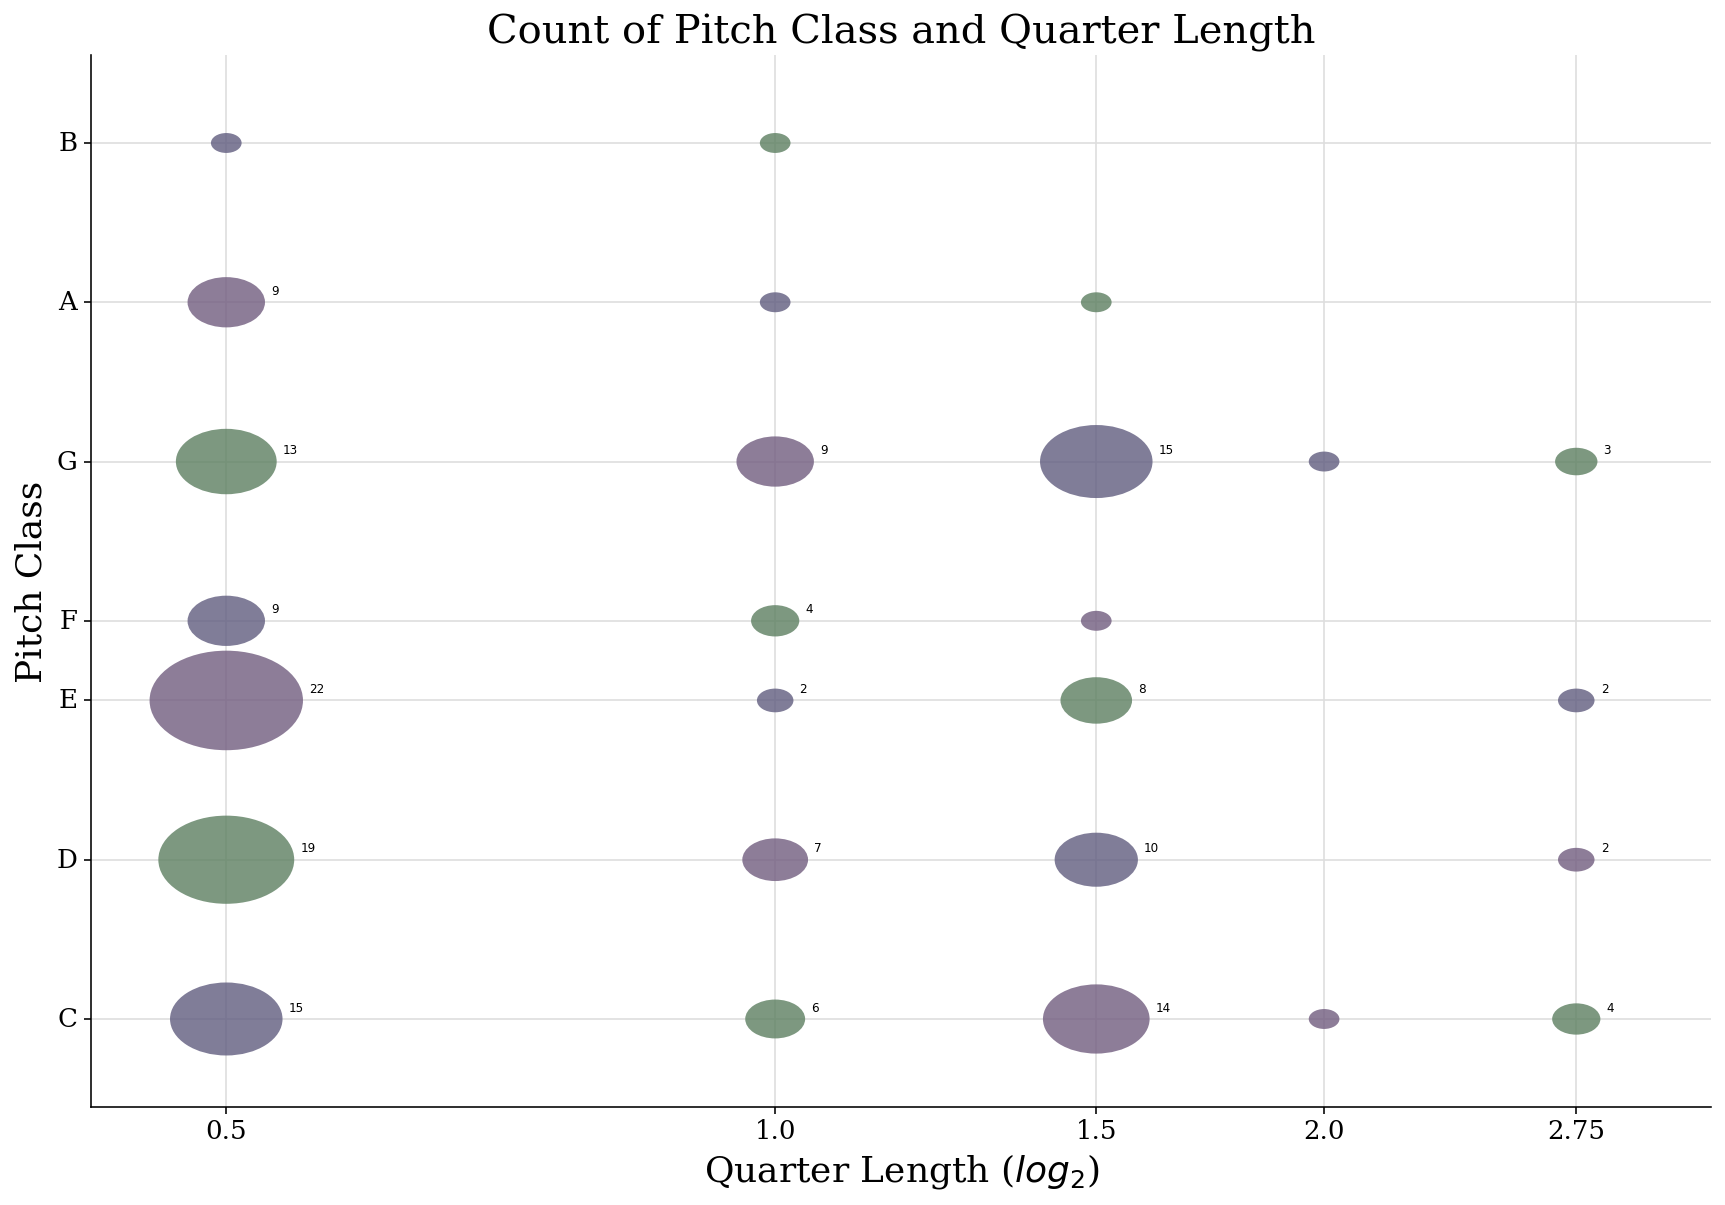

In [111]:
music.plot('scatterweighted', 'pitchClass', 'quarterLength',figureSize = (15,10),tickFontSize = 13,titleFontSize = 20, labelFontSize = 18,textFontSize = 12)

# Bidirectional LSTM model

In [19]:
#Model Architecture
model_bi = models.Sequential()
model_bi.add(layers.Bidirectional(layers.LSTM(256,return_sequences = True),input_shape = (lstm_input.shape[1],lstm_input.shape[2])))
model_bi.add(layers.Dropout(0.3))
model_bi.add(layers.Bidirectional(layers.LSTM(512)))
# model_bi.add(layers.Dropout(0.3))
model_bi.add(layers.Dense(n_class,activation = 'softmax'))

In [142]:
model_bi.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy',metrics = ['acc'])

In [143]:
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath ='../output/weights_bi_2layer1dropout.h5', monitor = 'loss',save_best_only = True ),
                  keras.callbacks.TensorBoard(log_dir = '../log_dir_bi_2layer1dropout',write_graph = True, update_freq = 'epoch')]

In [ ]:
model_bi.summary()

In [144]:
history = model_bi.fit(lstm_input, model_output, epochs = 40, batch_size = 64,callbacks = callbacks_list)

Epoch 1/40
5074/5074 [==============================] - 205s 40ms/step - loss: 4.6701 - acc: 0.0414
Epoch 2/40
5074/5074 [==============================] - 185s 37ms/step - loss: 4.3280 - acc: 0.0562
Epoch 3/40
5074/5074 [==============================] - 185s 36ms/step - loss: 4.1676 - acc: 0.0739
Epoch 4/40
5074/5074 [==============================] - 184s 36ms/step - loss: 4.0197 - acc: 0.0885
Epoch 5/40
5074/5074 [==============================] - 184s 36ms/step - loss: 3.8575 - acc: 0.1005
Epoch 6/40
5074/5074 [==============================] - 184s 36ms/step - loss: 3.6563 - acc: 0.1159
Epoch 7/40
5074/5074 [==============================] - 185s 36ms/step - loss: 3.4497 - acc: 0.1453
Epoch 8/40
5074/5074 [==============================] - 184s 36ms/step - loss: 3.1920 - acc: 0.1866
Epoch 9/40
5074/5074 [==============================] - 183s 36ms/step - loss: 2.9352 - acc: 0.2217
Epoch 10/40
5074/5074 [==============================] - 183s 36ms/step - loss: 2.7206 - acc: 0.2580

## Training loss plot

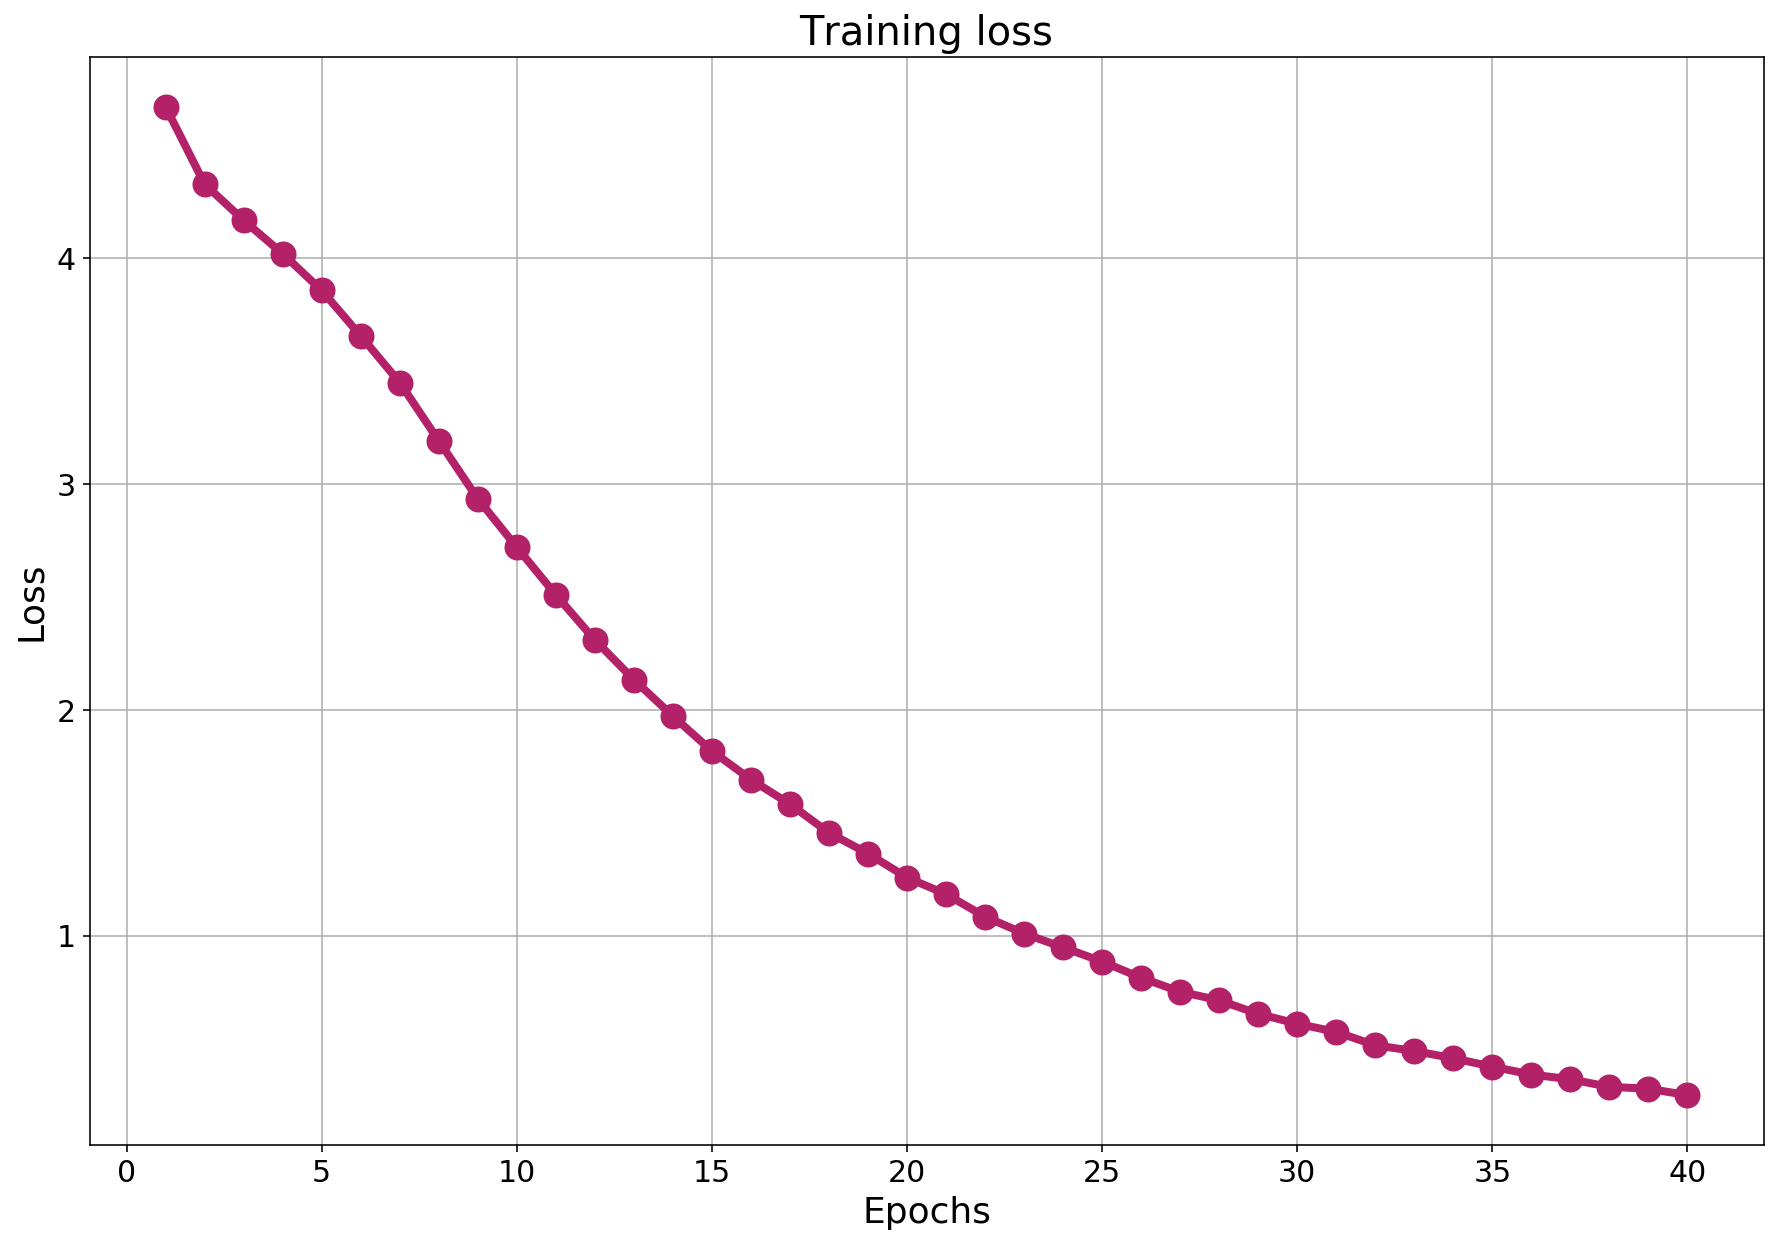

In [146]:
plt.plot(list(range(1,41,1)), history.history['loss'], color = '#B32268',marker = 'o',markersize = 12, linewidth = 4)

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

# Music Generation

In [570]:
#Model Architecture
model_bi = models.Sequential()
model_bi.add(layers.Bidirectional(layers.LSTM(256,return_sequences = True ),input_shape = (lstm_input.shape[1],lstm_input.shape[2])))
model_bi.add(layers.Dropout(0.3))
model_bi.add(layers.Bidirectional(layers.LSTM(512)))
#model_bi.add(layers.Dropout(0.3))
model_bi.add(layers.Dense(n_class,activation = 'softmax'))

In [571]:
model_bi.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy')

In [572]:
#Load the weights
model_bi.load_weights('../output/weights_bi_2layer1dropout.h5')

In [573]:
#Use the previous mapping dictionary to map integers to notes
int_to_note = {}
for i,j in mapping.items():
    int_to_note[j] = i
    

In [589]:
next_note = []
pattern = []

In [590]:
#Choose a random starting point from the list of input sequences
start_input_index = np.random.randint(0,len(input_int))
network_input = input_int[start_input_index]
pattern = input_int[start_input_index]

In [591]:
#Reweight the sampling to introduce randomness
def sample(preds, temperature):
    preds =  np.asarray(preds).astype('float64')
    preds = np.log(preds)/ temperature
    exp_preds = np.exp(preds)
    preds = exp_preds/np.sum(exp_preds)
    probas = np.random.multinomial(1,preds,1)
    return (probas)

In [592]:
num_notes_to_generate = 100

In [593]:
#Generate predictions from the model. Apply reweighted sampling
i=0
for num in range(100):
    network_input = np.reshape(network_input,(1,50,1))
    network_input = network_input.astype('float')/len(unique_notes)
    probs = model_bi.predict(network_input)[0]
  
    
    index = np.argmax(sample(probs,0.65))
#     print(index,np.max(sample(probs,0.75)),'\n')
    if index != np.argmax(probs):
        i = i+1
    pattern.append(index)
    
    network_input = pattern[num+1:len(pattern)]
print("Percentage of notes that were changed by sample reweight : {}%".format(i*100/num_notes_to_generate))  

Percentage of notes that were changed by sample reweight : 28.0%


In [594]:
#Length of the generated pattern ---This includes the input training sequence
len(pattern)

150

In [595]:
generated = []
output_notes = []
offset = 0

In [596]:
#Map the integers to the notes
for i in pattern[:]:
    generated.append(int_to_note[i])

In [597]:
# for i,j in enumerate(generated):
#     print(i,j)


In [598]:
output_notes = []
offset  = 0

In [599]:
from music21 import note

In [600]:
#For each element in the generated pattern, check if it is a note or a chord. If it is a note, create a note object 
#and append to the output. If it is a chord, create note objects for all the notes in the chord. Create a chord
#object with these note objects, and append to the output. Also, check the duration of the note and increase the offset
for element in generated:
    if bool(re.match(r'^[A-Z]',element)):
        l = element.split('$')
        n = note.Note(l[0])
        n.duration.quarterLength = eval(l[1])
        n.offset = offset
        output_notes.append(n)
        
    if bool(re.match(r'^\d',element)):
        l = element.split('$')
        le = l[0].split('.')
        notes_1 = []
        for ns in le:
            new_note = note.Note(int(ns))
            notes_1.append(new_note)
        ch = chord.Chord(notes_1)
        ch.duration.quarterLength = eval(l[1])
        ch.offset = offset
        output_notes.append(ch)
    
    offset = offset+eval(l[1])
        

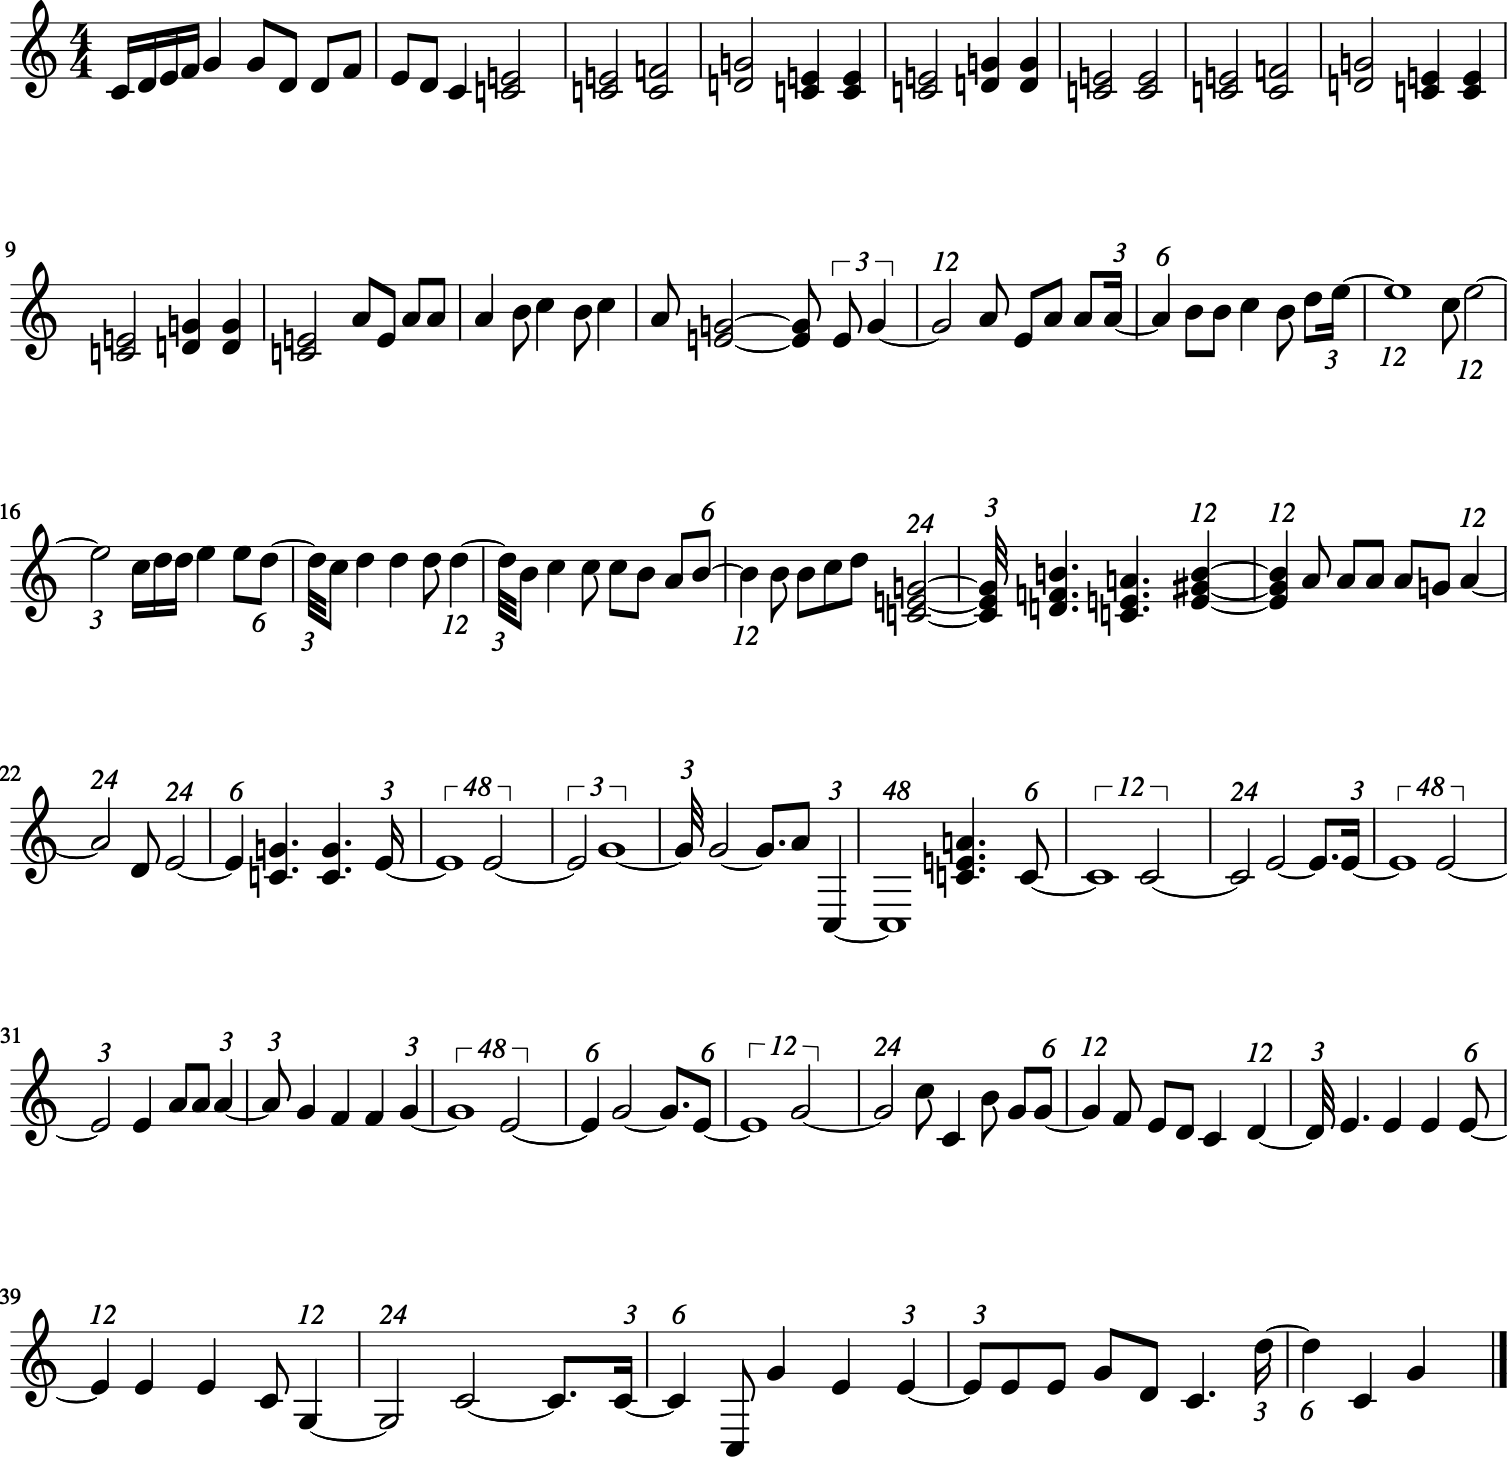

In [601]:
#Create a stream of all the output notes
music = stream.Stream(output_notes)
#View the stream
music.show()

In [602]:
#Convert to midi and write to disk
music.write('midi','../output/bilstm_2layer1dropout_sampled_0.65.mid')

'../output/bilstm_2layer1dropout_sampled_0.65.mid'

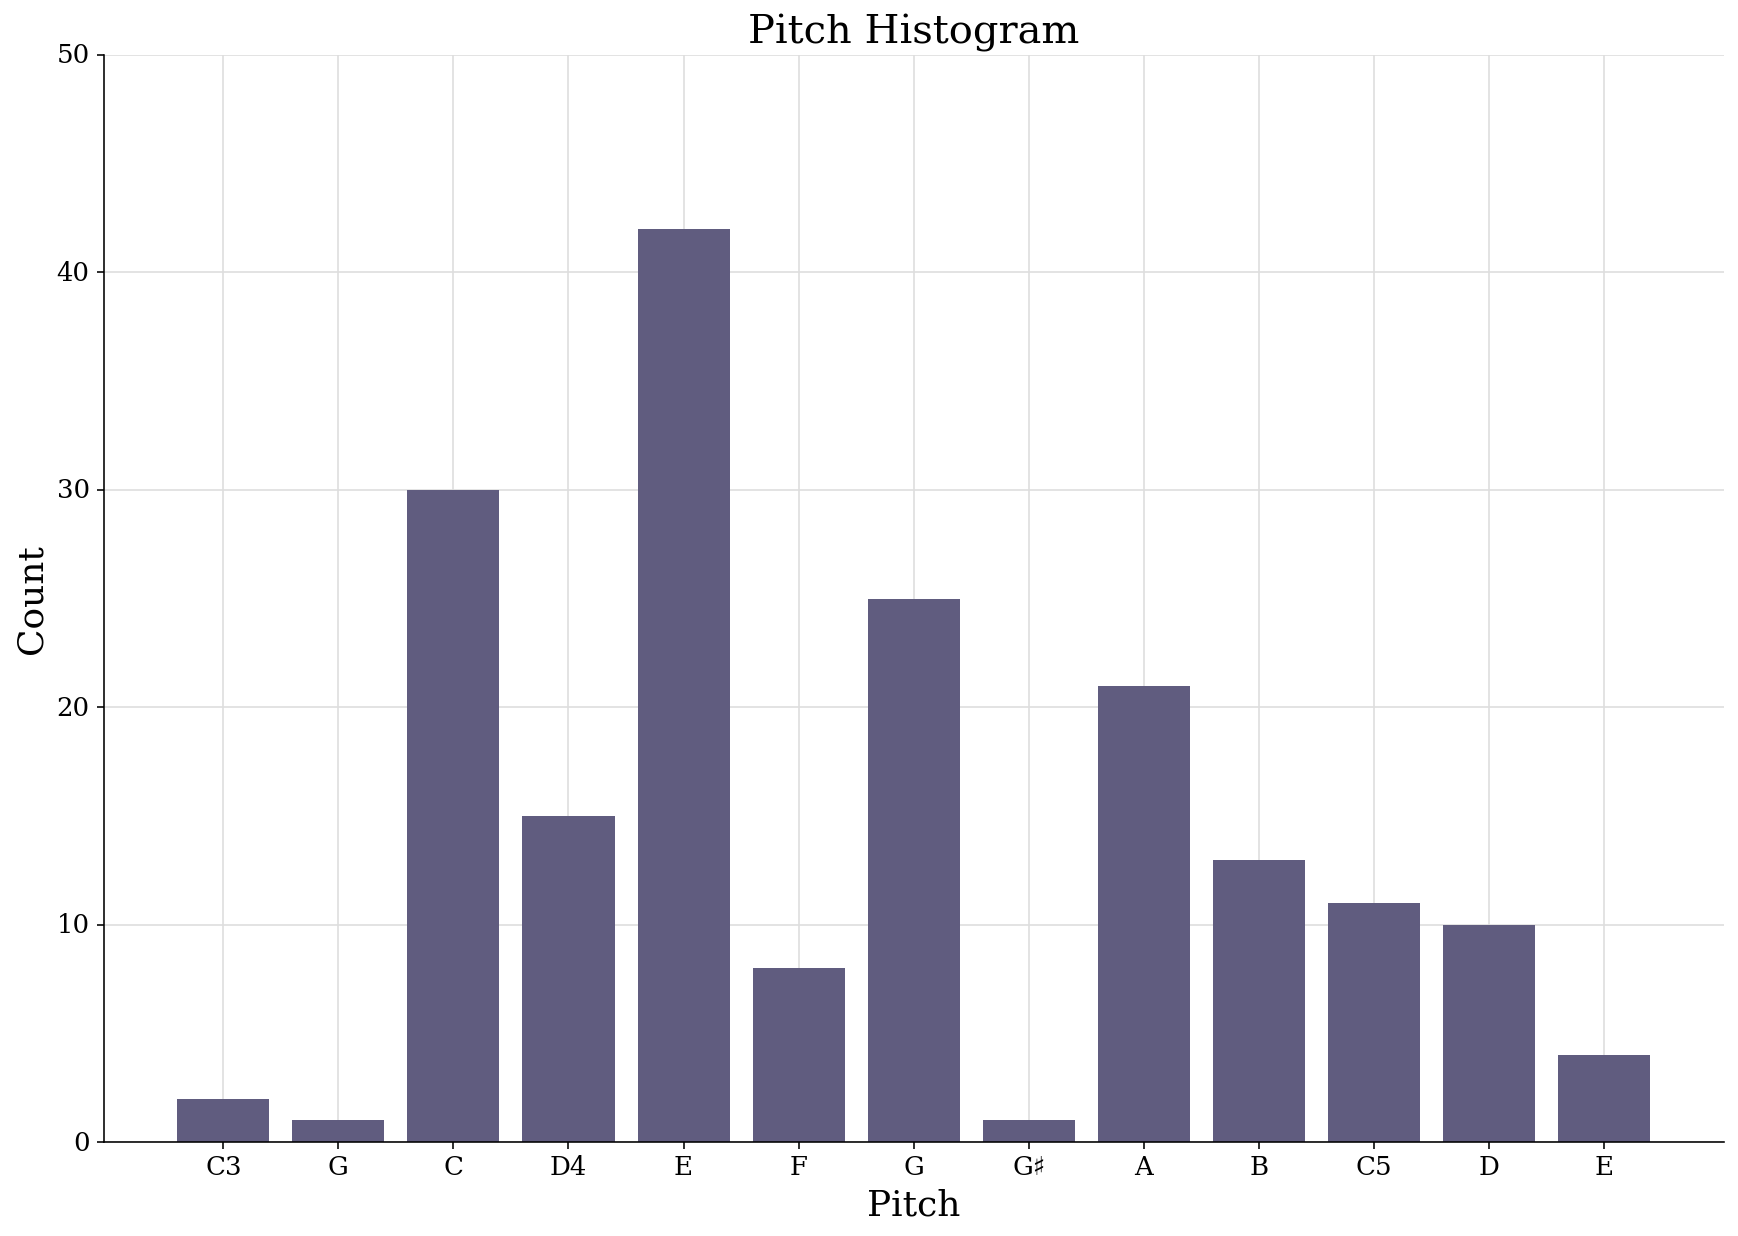

In [609]:
#Visualization of the output notes
music.plot('histogram','pitch',figureSize = (15,10),tickFontSize = 13,titleFontSize = 20, labelFontSize = 18,textFontSize = 12)

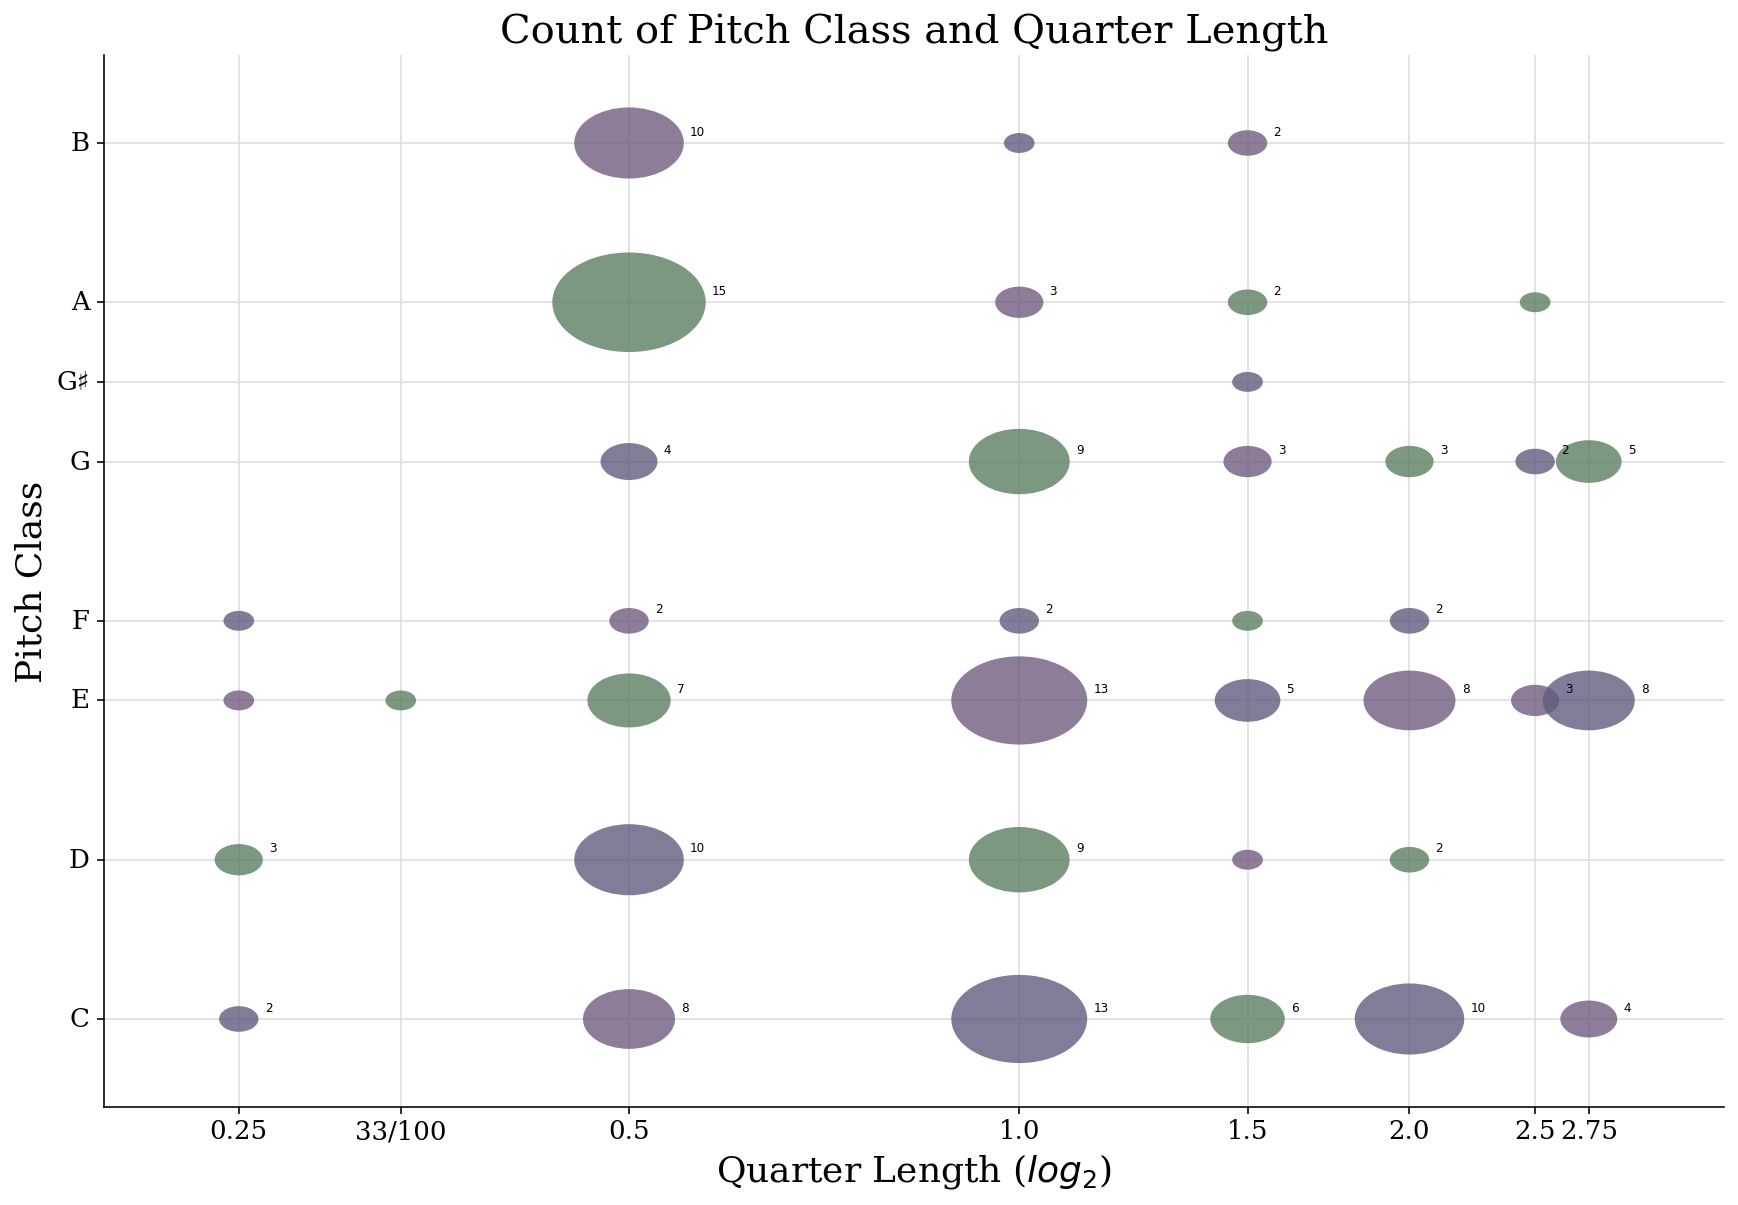

In [608]:
music.plot('scatterweighted','pitchClass','quarterlength',figureSize = (15,10),tickFontSize = 13,titleFontSize = 20, labelFontSize = 18,textFontSize = 12)

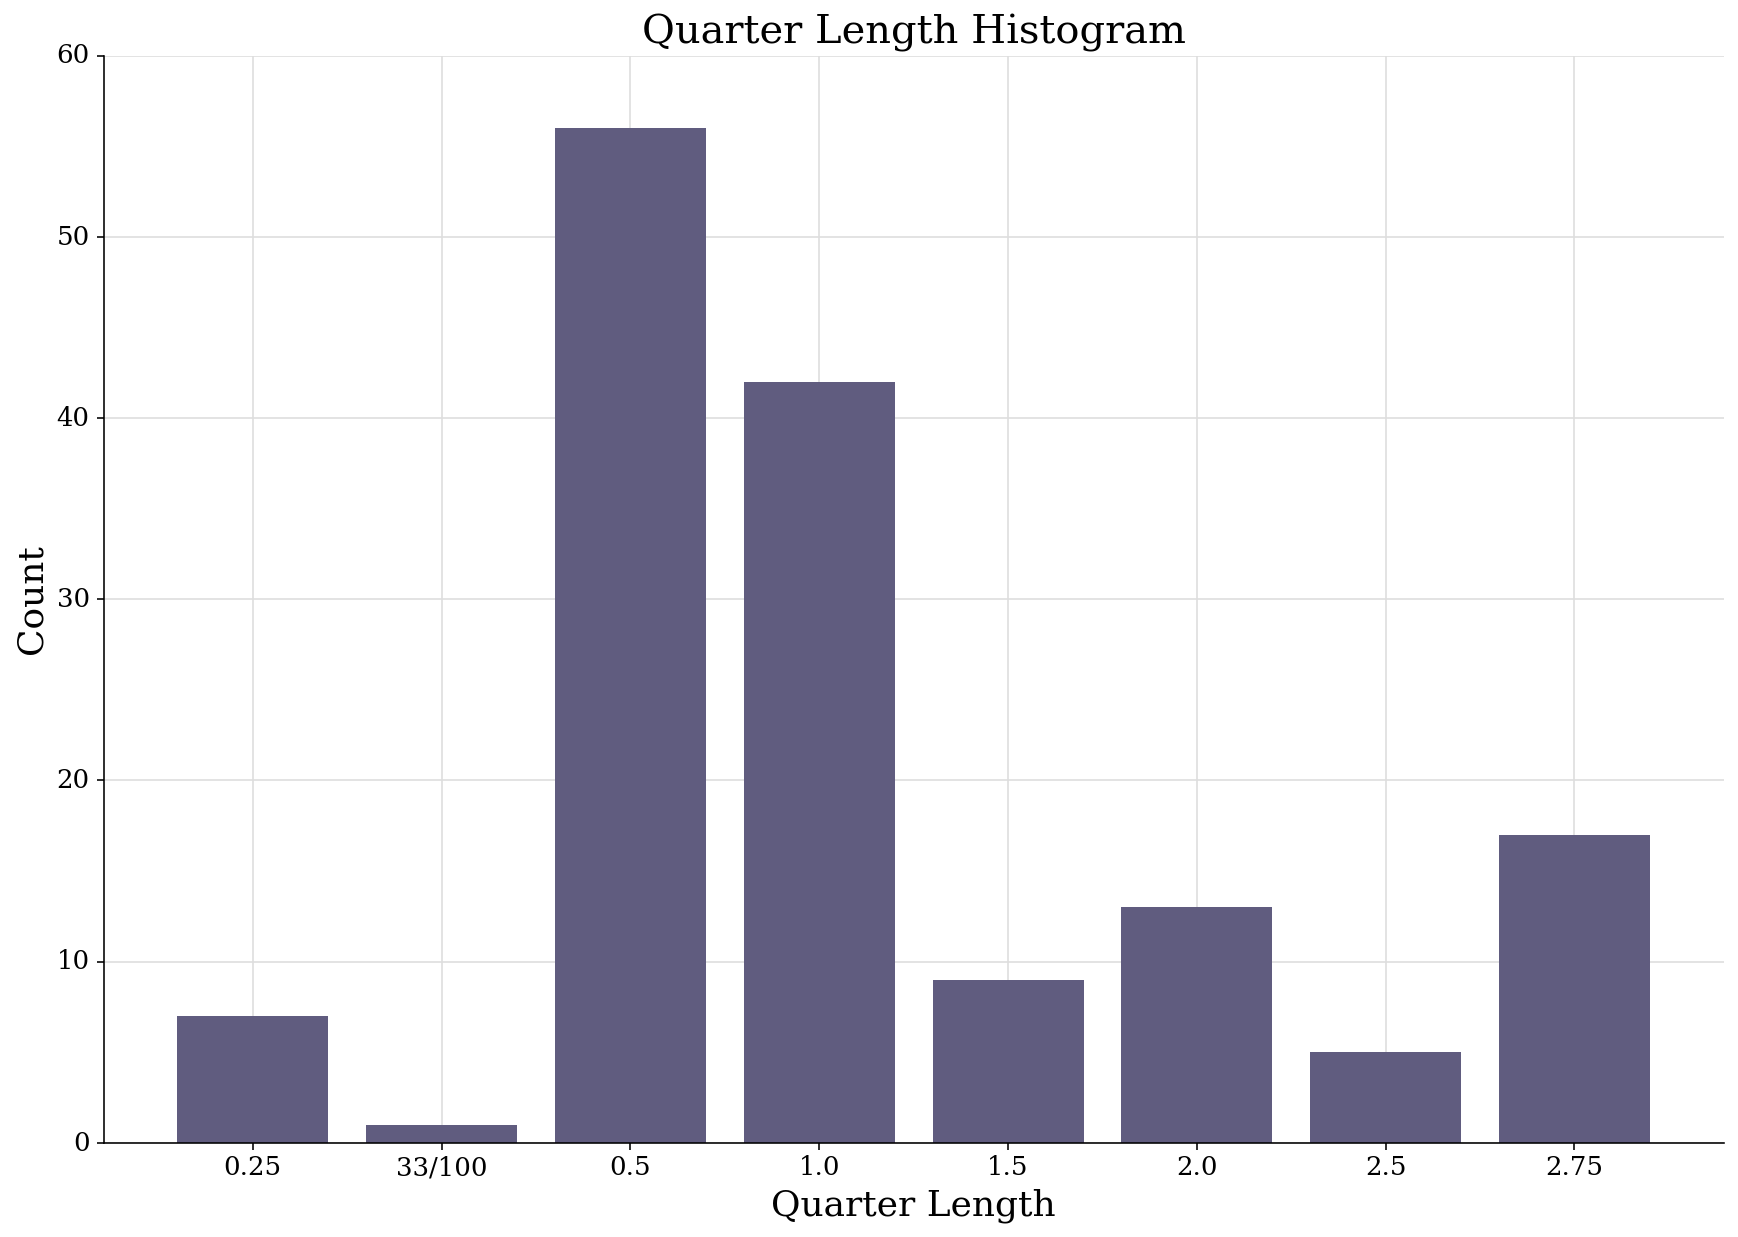

In [607]:
music.plot('histogram','quarterLength',figureSize = (15,10),tickFontSize = 13,titleFontSize = 20, labelFontSize = 18,textFontSize = 12)